In [2]:
#Set Up Modules:
#--------------------------------------------------------------------------------------
import numpy as np                 #library for working with arrays
import matplotlib.pyplot as plt    #libary for plotting (extension of numpy)
import re as regex                 #library for regular expressions
import cv2                         #libary to solve computer vision problems
import math                        #math tools
import random                      #library for randomization tools
import time                        #library for timing tools
import statistics as stat
import pickle

import winsound
import os, sys
from os import listdir, makedirs   #to use "listdir" and "mkdir"
from os.path import isfile, join, exists   #to use file tools
import copy


#Functions I wrote:
#-------------------------------------------------------------------
import CustomAssertions
import Distance
import Imaging
from Imaging import FrameManager, Background, CustomImage
import FeatureTools
import HandAssessments
from Analysis import StopWatch


In [21]:
#Prepare background images
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
def WriteSampleImageToFile(pathToImageFolder, imageName, img):
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    cv2.imwrite(pathToImage, img)
    
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder_1 = r"04-Data2\02-RawImages_BackgroundShots_Cut\00-RGB"
dataSubFolder_2 = r"04-Data2\02-RawImages_BackgroundShots_Cut\00-RGB"
ResultsSubfolder = r"04-Data2\03-BackgroundSamples_100x100\00-RGB"
fileSearchRE = "[0-9]_Feet_[0-9_]+.jpg"

#---options
imgShrinkFactor = 0.30     #% (fraction) of current size (keep aspect ratio)
finalImageSize = (100,100) #% ((pixels,pixels)) size of training sample image
singleStrat = False
showSamples = False

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
#initialize overall timing stuff
SelectiveSearchModel = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#grab new frame manager
frameManager_1 = FrameManager("", rootFolder, dataSubFolder_1, ResultsSubfolder, fileRegEx=fileSearchRE, COLOR="RGB")
frameManager_2 = FrameManager("", rootFolder, dataSubFolder_2, ResultsSubfolder, fileRegEx=fileSearchRE, COLOR="RGB")
if frameManager_1._managerStatus is -1:
    raise RuntimeError()

#run algorithm for one set of images 
globalCount = 0
imageCount = 0
while(frameManager_1.imagesOnStack >=1): 
    #update counters for image labeling
    globalCount += 1
    frameManager_1.setNextFrame()                             #get next frame on stack
    frameManager_2.setNextFrame()                             #get next frame on stack
    c_Frame_1 = frameManager_1.getCurrentFrame()                #snag current frame
    c_Frame_2 = frameManager_2.getCurrentFrame()                #snag current frame
    print("----> Frame: ", frameManager_1.currentImageName)   #print name of frame
    imgSize = np.shape(c_Frame_1.image)                       #capture image size (different sizes depending on cropping)
    img_1 = cv2.resize(c_Frame_1.image, 
                       (int(imgShrinkFactor*imgSize[1]), 
                        int(imgShrinkFactor*imgSize[0])), 
                        interpolation=cv2.INTER_AREA)          #resize the image; drone will do this too
    img_2 = cv2.resize(c_Frame_2.image, 
                       (int(imgShrinkFactor*imgSize[1]), 
                        int(imgShrinkFactor*imgSize[0])), 
                        interpolation=cv2.INTER_AREA)          #resize the image; drone will do this too
    
    SelectiveSearchModel.setBaseImage(img_1)
    SelectiveSearchModel.switchToSelectiveSearchFast()
    if singleStrat == True: 
        SelectiveSearchModel.switchToSingleStrategy()   
    else:
        rects = SelectiveSearchModel.process()
    print("---->BOXES FOUND:", len(rects))
        
    #show sample images
    if showSamples is True:
        test = img_2.copy()
        for (x, y, w, h) in rects:
            cv2.rectangle(test, (x, y), (x + w, y + h), [90,90,90], 2)
        Imaging.showImage(test)
        
    #parse out all sub-images from original image
    for (x, y, w, h) in rects:
        imageCount += 1
        output = img_2[y:y+h, x:x+w]
        output = cv2.resize(output, finalImageSize, interpolation=cv2.INTER_LANCZOS4)
        WriteSampleImageToFile(frameManager_2.fullPathToResults, "NOTBOX_%d_%d" % (globalCount, imageCount), output)
                


Number of images found -->  55
Number of images found -->  55
----> Frame:  1_Feet_125.jpg
---->BOXES FOUND: 437
----> Frame:  1_Feet_125_2.jpg
---->BOXES FOUND: 345
----> Frame:  1_Feet_14.jpg
---->BOXES FOUND: 577
----> Frame:  1_Feet_158.jpg
---->BOXES FOUND: 61
----> Frame:  1_Feet_182.jpg
---->BOXES FOUND: 724
----> Frame:  1_Feet_198.jpg
---->BOXES FOUND: 580
----> Frame:  1_Feet_198_2.jpg
---->BOXES FOUND: 486
----> Frame:  1_Feet_214.jpg
---->BOXES FOUND: 817
----> Frame:  1_Feet_214_2.jpg
---->BOXES FOUND: 744
----> Frame:  1_Feet_249.jpg
---->BOXES FOUND: 164
----> Frame:  1_Feet_262.jpg
---->BOXES FOUND: 322
----> Frame:  1_Feet_298.jpg
---->BOXES FOUND: 394
----> Frame:  1_Feet_298_2.jpg
---->BOXES FOUND: 369
----> Frame:  1_Feet_373.jpg
---->BOXES FOUND: 466
----> Frame:  1_Feet_385.jpg
---->BOXES FOUND: 473
----> Frame:  1_Feet_385_2.jpg
---->BOXES FOUND: 269
----> Frame:  1_Feet_385_3.jpg
---->BOXES FOUND: 170
----> Frame:  1_Feet_40.jpg
---->BOXES FOUND: 451
----> Frame

In [9]:
#Manually Select Boxes [ENSURE SIZE OF IMAGES WAS SAME AS THOSE FOR NON-BOX IMAGES]
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
def WriteLabelAndImageToFile(pathToImageFolder, imageName, buff, img):
    count = 0
    for item in buff:
        count +=1
        pathToLabel = pathToImageFolder + '\\' + imageName + "_" + str(count) + ".txt"
        pathToImage = pathToImageFolder + '\\' + imageName + "_" + str(count) + ".jpg"
        #write label file
        if os.path.isfile(pathToLabel):
            os.remove(pathToLabel)
        file = open(pathToLabel, 'a')
        file.write(str(item))
        file.close() 
        
        #write image
        outputImg = img[item[1]:item[1]+item[3], item[0]:item[0]+item[2]]
#         outputImg = cv2.resize(outputImg, finalImageSize, interpolation=cv2.INTER_LANCZOS4)
        cv2.imwrite(pathToImage, outputImg)

    
def CROP(event, x, y, flags, param):
    # grab references to the global variables
    global x_start, y_start, x_end, y_end, buffer, copyimg
    
    if event == cv2.EVENT_LBUTTONDOWN:
        x_start, y_start = x, y
    elif event == cv2.EVENT_LBUTTONUP:
        x_end, y_end = min(x,np.shape(copyimg)[1]-1), min(y,np.shape(copyimg)[0]-1)
        buffer.append(tuple([x_start, y_start, x_end-x_start, y_end-y_start, int(x_start + 0.5*(x_end-x_start)), int(y_start + 0.5*(y_end-y_start))]))
        print(buffer)
        copyimg = cv2.rectangle(copyimg, (x_start, y_start), (x_end, y_end), [99, 89, 223], 1)  
        
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data2\01-RawImages_All"
ResultsSubfolder = r"04-Data2\04-BoxSamples\00-RGB"
fileSearchRE = "[0-9]_Feet_[0-9_]+.jpg"

#---options
imgShrinkFactor = 0.30     #% (fraction) of current size (keep aspect ratio)
finalImageSize = (100,100) #% ((pixels,pixels)) size of training sample image
singleStrat = False
showSamples = False

distance = [4]
finalImageSize = (100,100)
#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------        
#initialize overall timing stuff
for dist in distance:
    #grab new frame manager
    frameManager = FrameManager("%d_Feet" % dist, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
    if frameManager._managerStatus is -1:
        continue

    #run algorithm for one set of images    
    color = [99, 89, 223]
    while(frameManager.imagesOnStack >=1): 
        buffer = []

        #set image into selective search process and run to get boxes
        frameManager.setNextFrame()   #get next frame on stack
        print('Operating on Image: ', frameManager.currentImageName)
        frameName = frameManager.currentImageName.split('.')[0]
        c_Frame = frameManager.getCurrentFrame()
        imgSize = np.shape(c_Frame.image)
        img = cv2.resize(c_Frame.image, (int(imgShrinkFactor*imgSize[1]), int(imgShrinkFactor*imgSize[0])), interpolation=cv2.INTER_AREA)
        print(np.shape(img))
        #set window where clicks should register
        cv2.namedWindow("image")
        cv2.setMouseCallback("image", CROP)            

        copyimg = copy.deepcopy(img)
        while True:
            cv2.imshow("image", copyimg)
            key = cv2.waitKey(1) & 0xFF

            #options
            if key == ord("b"): copyimg = copy.deepcopy(img); buffer = []
            elif key == ord("u"): 
                print("Updating Image")
                for buff in buffer:
                    copyimg = cv2.rectangle(copyimg, (buff[0], buff[1]), (buff[0]+buff[2], buff[1]+buff[3]), [99, 89, 223], 1)
            elif key == ord("p"): print("Buffer:", buffer); 
            elif key == ord("c"): print("Going to next image..."); break 
            elif key == ord("s"): print("Going to next image set..."); break
            elif key == ord("q"): print("Quitting..."); break

        #what to do now?
        if len(buffer) > 0:
            print("writing stuff")
            WriteLabelAndImageToFile(frameManager.fullPathToResults, frameManager.currentImageName.split('.')[0], buffer, img)
        cv2.destroyAllWindows()  

        if key == ord("q"): #quit
            print("Writing buffer to file...")
            sys.exit()
        if key == ord("s"): #skip image, go to next
            break
            

import winsound
winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)
print("Main: All images finished.")

Number of images found -->  638
Operating on Image:  4_Feet_1.jpg
(216, 288, 3)
[(65, 0, 116, 42, 123, 21)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_10.jpg
(216, 288, 3)
[(47, 2, 110, 88, 102, 46)]
[(47, 2, 110, 88, 102, 46), (60, 85, 106, 94, 113, 132)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_100.jpg
(216, 288, 3)
[(44, 57, 87, 85, 87, 99)]
[(44, 57, 87, 85, 87, 99), (48, 122, 86, 93, 91, 168)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_101.jpg
(216, 288, 3)
[(55, 56, 84, 84, 97, 98)]
[(55, 56, 84, 84, 97, 98), (55, 121, 88, 94, 99, 168)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_102.jpg
(216, 288, 3)
[(74, 57, 83, 86, 115, 100)]
[(74, 57, 83, 86, 115, 100), (75, 123, 83, 92, 116, 169)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_103.jpg
(216, 288, 3)
[(95, 58, 83, 86, 136, 101)]
[(95, 58, 83, 86, 136, 101), (94, 122, 88, 93, 138, 168)]
Going to next image...
writing stuf

[(72, 45, 75, 88, 109, 89), (63, 107, 83, 102, 104, 158)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_141.jpg
(216, 288, 3)
[(62, 114, 85, 101, 104, 164)]
[(62, 114, 85, 101, 104, 164), (68, 53, 77, 88, 106, 97)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_142.jpg
(216, 288, 3)
[(53, 65, 80, 87, 93, 108)]
[(53, 65, 80, 87, 93, 108), (49, 128, 91, 87, 94, 171)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_143.jpg
(216, 288, 3)
[(47, 70, 78, 83, 86, 111)]
[(46, 70, 84, 85, 88, 112)]
[(46, 70, 84, 85, 88, 112), (46, 132, 86, 83, 89, 173)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_144.jpg
(216, 288, 3)
[(60, 80, 83, 86, 101, 123)]
[(60, 80, 83, 86, 101, 123), (62, 142, 85, 73, 104, 178)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_145.jpg
(216, 288, 3)
[(76, 84, 77, 86, 114, 127)]
[(76, 84, 77, 86, 114, 127), (73, 147, 84, 68, 115, 181)]
Going to next image...
writing stuff
Operating o

Going to next image...
writing stuff
Operating on Image:  4_Feet_186.jpg
(216, 288, 3)
[(80, 65, 54, 87, 107, 108)]
[(80, 65, 54, 87, 107, 108), (76, 127, 59, 88, 105, 171)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_187.jpg
(216, 288, 3)
[(87, 66, 56, 85, 115, 108)]
[(87, 66, 56, 85, 115, 108), (86, 130, 63, 85, 117, 172)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_188.jpg
(216, 288, 3)
[(88, 63, 57, 84, 116, 105)]
[(88, 63, 57, 84, 116, 105), (87, 122, 66, 93, 120, 168)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_189.jpg
(216, 288, 3)
Going to next image...
Operating on Image:  4_Feet_19.jpg
(216, 288, 3)
[(91, 61, 98, 80, 140, 101)]
[(91, 61, 98, 80, 140, 101), (89, 136, 93, 79, 135, 175)]
[(92, 136, 92, 79, 138, 175)]
[(92, 136, 92, 79, 138, 175), (92, 64, 98, 78, 141, 103)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_190.jpg
(216, 288, 3)
[(71, 61, 60, 84, 101, 103)]
[(71, 61, 60, 84, 101, 103),

Going to next image...
writing stuff
Operating on Image:  4_Feet_227.jpg
(216, 288, 3)
[(113, 53, 37, 88, 131, 97)]
[(113, 54, 42, 88, 134, 98)]
[(113, 54, 42, 88, 134, 98), (102, 117, 58, 98, 131, 166)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_228.jpg
(216, 288, 3)
[(120, 74, 40, 87, 140, 117)]
[(120, 74, 40, 87, 140, 117), (113, 146, 53, 69, 139, 180)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_229.jpg
(216, 288, 3)
[(119, 69, 43, 87, 140, 112)]
[(119, 69, 43, 87, 140, 112), (115, 138, 50, 77, 140, 176)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_23.jpg
(216, 288, 3)
[(49, 60, 100, 82, 99, 101)]
[(49, 60, 100, 82, 99, 101), (51, 134, 87, 81, 94, 174)]
[(51, 61, 99, 82, 100, 102)]
[(51, 61, 99, 82, 100, 102), (47, 134, 94, 81, 94, 174)]
[(52, 134, 89, 81, 96, 174)]
[(52, 134, 89, 81, 96, 174), (52, 61, 96, 82, 100, 102)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_230.jpg
(216, 288, 3)
[(117, 74, 

[(240, 61, 47, 89, 263, 105)]
[(240, 61, 47, 89, 263, 105), (231, 140, 56, 75, 259, 177)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_268.jpg
(216, 288, 3)
[(225, 64, 62, 91, 256, 109)]
[(225, 64, 62, 91, 256, 109), (219, 145, 68, 70, 253, 180)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_269.jpg
(216, 288, 3)
[(212, 59, 75, 87, 249, 102)]
[(212, 59, 75, 87, 249, 102), (202, 139, 85, 76, 244, 177)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_27.jpg
(216, 288, 3)
[(1, 66, 63, 84, 32, 108)]
[(1, 66, 63, 84, 32, 108), (1, 145, 61, 70, 31, 180)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_270.jpg
(216, 288, 3)
[(204, 62, 83, 86, 245, 105)]
[(204, 62, 83, 86, 245, 105), (201, 137, 86, 78, 244, 176)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_271.jpg
(216, 288, 3)
[(205, 53, 82, 83, 246, 94)]
[(205, 53, 82, 83, 246, 94), (198, 129, 89, 86, 242, 172)]
Going to next image...
writing stuff


[(122, 61, 76, 77, 160, 99)]
[(122, 61, 76, 77, 160, 99), (113, 123, 84, 92, 155, 169)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_31.jpg
(216, 288, 3)
[(1, 66, 45, 82, 23, 107)]
[(1, 66, 45, 82, 23, 107), (1, 147, 46, 68, 24, 181)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_310.jpg
(216, 288, 3)
[(126, 64, 79, 74, 165, 101)]
[(126, 64, 79, 74, 165, 101), (115, 126, 91, 89, 160, 170)]
[(120, 126, 88, 89, 164, 170)]
[(120, 126, 88, 89, 164, 170), (126, 61, 78, 76, 165, 99)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_311.jpg
(216, 288, 3)
[(138, 69, 81, 77, 178, 107)]
[(138, 69, 81, 77, 178, 107), (132, 135, 88, 80, 176, 175)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_312.jpg
(216, 288, 3)
[(144, 73, 80, 78, 184, 112)]
[(140, 74, 83, 75, 181, 111)]
[(140, 74, 83, 75, 181, 111), (131, 141, 97, 74, 179, 178)]
[(134, 141, 95, 74, 181, 178)]
[(134, 135, 91, 80, 179, 175)]
[(134, 135, 91, 80, 179, 175), (

[(174, 64, 94, 71, 221, 99)]
[(174, 64, 94, 71, 221, 99), (167, 131, 100, 84, 217, 173)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_353.jpg
(216, 288, 3)
[(166, 65, 95, 71, 213, 100)]
[(166, 65, 95, 71, 213, 100), (165, 135, 96, 80, 213, 175)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_354.jpg
(216, 288, 3)
[(163, 70, 96, 76, 211, 108)]
[(163, 70, 96, 76, 211, 108), (161, 138, 93, 77, 207, 176)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_355.jpg
(216, 288, 3)
[(169, 72, 96, 81, 217, 112)]
[(169, 72, 96, 81, 217, 112), (154, 144, 105, 71, 206, 179)]
[(157, 143, 101, 72, 207, 179)]
[(157, 143, 101, 72, 207, 179), (167, 75, 100, 77, 217, 113)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_356.jpg
(216, 288, 3)
[(152, 73, 99, 81, 201, 113)]
[(152, 73, 99, 81, 201, 113), (139, 143, 102, 72, 190, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_357.jpg
(216, 288, 3)
[(132, 64, 97, 80, 1

[(87, 96, 105, 83, 139, 137)]
[(87, 96, 105, 83, 139, 137), (92, 173, 109, 42, 146, 194)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_397.jpg
(216, 288, 3)
[(85, 84, 107, 78, 138, 123)]
[(85, 84, 107, 78, 138, 123), (88, 157, 112, 58, 144, 186)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_398.jpg
(216, 288, 3)
[(82, 69, 110, 80, 137, 109)]
[(82, 69, 110, 80, 137, 109), (88, 143, 111, 72, 143, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_399.jpg
(216, 288, 3)
[(74, 50, 110, 81, 129, 90)]
[(74, 50, 110, 81, 129, 90), (78, 127, 115, 88, 135, 171)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_4.jpg
(216, 288, 3)
[(78, 127, 72, -56, 114, 99)]
[(29, 0, 123, 67, 90, 33)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_40.jpg
(216, 288, 3)
[(134, 69, 97, 73, 182, 105)]
[(134, 69, 97, 73, 182, 105), (136, 141, 87, 74, 179, 178)]
Going to next image...
writing stuff
Operating on Image:  4_Fee

Going to next image...
writing stuff
Operating on Image:  4_Feet_44.jpg
(216, 288, 3)
[(191, 66, 96, 75, 239, 103)]
[(191, 66, 96, 75, 239, 103), (193, 133, 94, 82, 240, 174)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_440.jpg
(216, 288, 3)
[(36, 57, 83, 80, 77, 97)]
[(36, 57, 83, 80, 77, 97), (29, 119, 87, 96, 72, 167)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_441.jpg
(216, 288, 3)
[(13, 49, 90, 79, 58, 88)]
[(13, 49, 90, 79, 58, 88), (9, 113, 93, 102, 55, 164)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_442.jpg
(216, 288, 3)
[(9, 56, 89, 80, 53, 96)]
[(9, 56, 89, 80, 53, 96), (2, 122, 95, 93, 49, 168)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_443.jpg
(216, 288, 3)
[(0, 47, 88, 84, 44, 89)]
[(0, 47, 88, 84, 44, 89), (0, 114, 85, 101, 42, 164)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_444.jpg
(216, 288, 3)
[(2, 45, 81, 84, 42, 87)]
[(2, 45, 81, 84, 42, 87), (2, 116, 77, 9

[(123, 82, 80, 83, 163, 123), (120, 143, 87, 72, 163, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_483.jpg
(216, 288, 3)
[(152, 1, 49, 67, 176, 34)]
[(152, 1, 49, 67, 176, 34), (135, 53, 54, 110, 162, 108)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_484.jpg
(216, 288, 3)
[(152, 1, 42, 71, 173, 36)]
[(152, 1, 42, 71, 173, 36), (135, 53, 54, 111, 162, 108)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_485.jpg
(216, 288, 3)
[(132, 58, 52, 107, 158, 111)]
[(132, 58, 52, 107, 158, 111), (150, 0, 41, 73, 170, 36)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_486.jpg
(216, 288, 3)
[(127, 56, 51, 106, 152, 109)]
[(127, 56, 51, 106, 152, 109), (139, 0, 44, 75, 161, 37)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_487.jpg
(216, 288, 3)
[(117, 74, 51, 105, 142, 126)]
[(117, 74, 51, 105, 142, 126), (131, 11, 39, 84, 150, 53)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_

[(104, 97, 46, 78, 127, 136)]
[(104, 97, 46, 78, 127, 136), (97, 151, 53, 64, 123, 183)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_523.jpg
(216, 288, 3)
[(93, 97, 50, 77, 118, 135)]
[(93, 97, 50, 77, 118, 135), (86, 153, 56, 62, 114, 184)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_524.jpg
(216, 288, 3)
[(104, 93, 52, 79, 130, 132)]
[(104, 93, 52, 79, 130, 132), (97, 148, 60, 67, 127, 181)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_525.jpg
(216, 288, 3)
[(118, 92, 55, 79, 145, 131)]
[(118, 92, 55, 79, 145, 131), (111, 147, 63, 68, 142, 181)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_526.jpg
(216, 288, 3)
[(130, 88, 61, 75, 160, 125)]
[(130, 88, 61, 75, 160, 125), (125, 144, 65, 71, 157, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_527.jpg
(216, 288, 3)
[(146, 89, 62, 78, 177, 128)]
[(146, 89, 62, 78, 177, 128), (143, 145, 64, 70, 175, 180)]
Going to next image...
writing

[(148, 52, 77, 79, 186, 91)]
[(148, 52, 77, 79, 186, 91), (143, 115, 85, 100, 185, 165)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_569.jpg
(216, 288, 3)
[(158, 46, 76, 77, 196, 84)]
[(157, 46, 78, 79, 196, 85)]
[(157, 46, 78, 79, 196, 85), (151, 109, 87, 102, 194, 160)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_57.jpg
(216, 288, 3)
[(58, 67, 99, 74, 107, 104)]
[(58, 67, 99, 74, 107, 104), (64, 140, 92, 75, 110, 177)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_570.jpg
(216, 288, 3)
[(153, 61, 74, 83, 190, 102)]
[(153, 62, 72, 87, 189, 105)]
[(153, 62, 72, 87, 189, 105), (146, 129, 83, 86, 187, 172)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_571.jpg
(216, 288, 3)
[(149, 65, 71, 89, 184, 109)]
[(147, 74, 73, 77, 183, 112)]
[(144, 69, 76, 81, 182, 109)]
[(144, 69, 80, 81, 184, 109)]
[(144, 69, 80, 81, 184, 109), (135, 131, 83, 84, 176, 173)]
Going to next image...
writing stuff
Operating on Image:  4

[(74, 59, 80, 81, 114, 99)]
[(74, 59, 80, 81, 114, 99), (67, 122, 89, 93, 111, 168)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_611.jpg
(216, 288, 3)
[(109, 53, 79, 80, 148, 93)]
[(109, 53, 79, 80, 148, 93), (103, 115, 89, 100, 147, 165)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_612.jpg
(216, 288, 3)
[(128, 60, 85, 76, 170, 98)]
[(128, 60, 85, 76, 170, 98), (123, 126, 83, 89, 164, 170)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_613.jpg
(216, 288, 3)
[(152, 65, 81, 76, 192, 103)]
[(152, 65, 81, 76, 192, 103), (145, 128, 87, 87, 188, 171)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_614.jpg
(216, 288, 3)
[(151, 66, 80, 85, 191, 108)]
[(151, 66, 80, 85, 191, 108), (145, 130, 88, 85, 189, 172)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_615.jpg
(216, 288, 3)
[(147, 76, 79, 85, 186, 118)]
[(147, 76, 79, 85, 186, 118), (140, 140, 88, 75, 184, 177)]
Going to next image...
writing st

[(120, 72, 96, 82, 168, 113)]
[(120, 72, 96, 82, 168, 113), (115, 144, 91, 71, 160, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_8.jpg
(216, 288, 3)
[(115, 144, 53, -83, 141, 102)]
[(53, 1, 116, 63, 111, 32)]
[(53, 1, 116, 63, 111, 32), (61, 60, 109, 99, 115, 109)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_80.jpg
(216, 288, 3)
[(135, 70, 102, 81, 186, 110)]
[(135, 70, 102, 81, 186, 110), (127, 140, 93, 75, 173, 177)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_81.jpg
(216, 288, 3)
[(136, 70, 103, 82, 187, 111)]
[(134, 69, 101, 80, 184, 109)]
[(134, 69, 101, 80, 184, 109), (125, 144, 99, 71, 174, 179)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_82.jpg
(216, 288, 3)
[(70, 1, 102, 70, 121, 36)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_83.jpg
(216, 288, 3)
[(72, 0, 100, 73, 122, 36)]
Going to next image...
writing stuff
Operating on Image:  4_Feet_84.jpg
(216, 288, 3)
[(70, 1

In [28]:
import shutil
import winsound

def WriteImageToFile(pathToImageFolder, imageName, img):
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    cv2.imwrite(pathToImage, img)

#Finally, Generate Images and Labels, and pickle them :) 
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data2\04-BoxSamples\00-RGB"
ResultsSubfolder = r"04-Data2\04-BoxSamples_50x50\00-RGB"
fileSearchRE = "[0-9]_Feet_[0-9_]+.jpg"

#---options
imgShrinkFactor = 0.30     #% (fraction) of current size (keep aspect ratio)
finalImageSize = (50,50) #% ((pixels,pixels)) size of training sample image
singleStrat = False
showSamples = False

distance = [1,2,3,4]
#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
#initialize overall timing stuff
globalCount = 0
for dist in distance:
    globalCount += 1
    #grab new frame manager
    frameManager = FrameManager("%d_Feet" % dist, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
    if frameManager._managerStatus is -1:
        continue

    #run algorithm for one set of images  
    counter = frameManager.imagesOnStack
    imageCount = 0
    while(frameManager.imagesOnStack >=1): 
        frameManager.setNextFrame()   #get next frame on stack
        print('Progress: %d of %d' % (counter - frameManager.imagesOnStack, counter))
        frameName = frameManager.currentImageName.split('.')[0]
        c_Frame = frameManager.getCurrentFrame()
        imgSize = np.shape(c_Frame.image)
        img = cv2.resize(c_Frame.image, finalImageSize, interpolation=cv2.INTER_LANCZOS4)
        imageCount += 1
        WriteImageToFile(frameManager.fullPathToResults, "BOX_%d_%d" % (globalCount, imageCount), img)
        shutil.copyfile(join(frameManager.fullPathToSource,frameName + ".txt"), join(frameManager.fullPathToResults,"BOX_%d_%d.txt" % (globalCount, imageCount)))
        
winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)
print("Main: All images finished.")       

Number of images found -->  649
Progress: 1 of 649
Progress: 2 of 649
Progress: 3 of 649
Progress: 4 of 649
Progress: 5 of 649
Progress: 6 of 649
Progress: 7 of 649
Progress: 8 of 649
Progress: 9 of 649
Progress: 10 of 649
Progress: 11 of 649
Progress: 12 of 649
Progress: 13 of 649
Progress: 14 of 649
Progress: 15 of 649
Progress: 16 of 649
Progress: 17 of 649
Progress: 18 of 649
Progress: 19 of 649
Progress: 20 of 649
Progress: 21 of 649
Progress: 22 of 649
Progress: 23 of 649
Progress: 24 of 649
Progress: 25 of 649
Progress: 26 of 649
Progress: 27 of 649
Progress: 28 of 649
Progress: 29 of 649
Progress: 30 of 649
Progress: 31 of 649
Progress: 32 of 649
Progress: 33 of 649
Progress: 34 of 649
Progress: 35 of 649
Progress: 36 of 649
Progress: 37 of 649
Progress: 38 of 649
Progress: 39 of 649
Progress: 40 of 649
Progress: 41 of 649
Progress: 42 of 649
Progress: 43 of 649
Progress: 44 of 649
Progress: 45 of 649
Progress: 46 of 649
Progress: 47 of 649
Progress: 48 of 649
Progress: 49 of 6

Progress: 440 of 649
Progress: 441 of 649
Progress: 442 of 649
Progress: 443 of 649
Progress: 444 of 649
Progress: 445 of 649
Progress: 446 of 649
Progress: 447 of 649
Progress: 448 of 649
Progress: 449 of 649
Progress: 450 of 649
Progress: 451 of 649
Progress: 452 of 649
Progress: 453 of 649
Progress: 454 of 649
Progress: 455 of 649
Progress: 456 of 649
Progress: 457 of 649
Progress: 458 of 649
Progress: 459 of 649
Progress: 460 of 649
Progress: 461 of 649
Progress: 462 of 649
Progress: 463 of 649
Progress: 464 of 649
Progress: 465 of 649
Progress: 466 of 649
Progress: 467 of 649
Progress: 468 of 649
Progress: 469 of 649
Progress: 470 of 649
Progress: 471 of 649
Progress: 472 of 649
Progress: 473 of 649
Progress: 474 of 649
Progress: 475 of 649
Progress: 476 of 649
Progress: 477 of 649
Progress: 478 of 649
Progress: 479 of 649
Progress: 480 of 649
Progress: 481 of 649
Progress: 482 of 649
Progress: 483 of 649
Progress: 484 of 649
Progress: 485 of 649
Progress: 486 of 649
Progress: 487

Progress: 272 of 686
Progress: 273 of 686
Progress: 274 of 686
Progress: 275 of 686
Progress: 276 of 686
Progress: 277 of 686
Progress: 278 of 686
Progress: 279 of 686
Progress: 280 of 686
Progress: 281 of 686
Progress: 282 of 686
Progress: 283 of 686
Progress: 284 of 686
Progress: 285 of 686
Progress: 286 of 686
Progress: 287 of 686
Progress: 288 of 686
Progress: 289 of 686
Progress: 290 of 686
Progress: 291 of 686
Progress: 292 of 686
Progress: 293 of 686
Progress: 294 of 686
Progress: 295 of 686
Progress: 296 of 686
Progress: 297 of 686
Progress: 298 of 686
Progress: 299 of 686
Progress: 300 of 686
Progress: 301 of 686
Progress: 302 of 686
Progress: 303 of 686
Progress: 304 of 686
Progress: 305 of 686
Progress: 306 of 686
Progress: 307 of 686
Progress: 308 of 686
Progress: 309 of 686
Progress: 310 of 686
Progress: 311 of 686
Progress: 312 of 686
Progress: 313 of 686
Progress: 314 of 686
Progress: 315 of 686
Progress: 316 of 686
Progress: 317 of 686
Progress: 318 of 686
Progress: 319

Progress: 667 of 686
Progress: 668 of 686
Progress: 669 of 686
Progress: 670 of 686
Progress: 671 of 686
Progress: 672 of 686
Progress: 673 of 686
Progress: 674 of 686
Progress: 675 of 686
Progress: 676 of 686
Progress: 677 of 686
Progress: 678 of 686
Progress: 679 of 686
Progress: 680 of 686
Progress: 681 of 686
Progress: 682 of 686
Progress: 683 of 686
Progress: 684 of 686
Progress: 685 of 686
Progress: 686 of 686
Number of images found -->  831
Progress: 1 of 831
Progress: 2 of 831
Progress: 3 of 831
Progress: 4 of 831
Progress: 5 of 831
Progress: 6 of 831
Progress: 7 of 831
Progress: 8 of 831
Progress: 9 of 831
Progress: 10 of 831
Progress: 11 of 831
Progress: 12 of 831
Progress: 13 of 831
Progress: 14 of 831
Progress: 15 of 831
Progress: 16 of 831
Progress: 17 of 831
Progress: 18 of 831
Progress: 19 of 831
Progress: 20 of 831
Progress: 21 of 831
Progress: 22 of 831
Progress: 23 of 831
Progress: 24 of 831
Progress: 25 of 831
Progress: 26 of 831
Progress: 27 of 831
Progress: 28 of 8

Progress: 399 of 831
Progress: 400 of 831
Progress: 401 of 831
Progress: 402 of 831
Progress: 403 of 831
Progress: 404 of 831
Progress: 405 of 831
Progress: 406 of 831
Progress: 407 of 831
Progress: 408 of 831
Progress: 409 of 831
Progress: 410 of 831
Progress: 411 of 831
Progress: 412 of 831
Progress: 413 of 831
Progress: 414 of 831
Progress: 415 of 831
Progress: 416 of 831
Progress: 417 of 831
Progress: 418 of 831
Progress: 419 of 831
Progress: 420 of 831
Progress: 421 of 831
Progress: 422 of 831
Progress: 423 of 831
Progress: 424 of 831
Progress: 425 of 831
Progress: 426 of 831
Progress: 427 of 831
Progress: 428 of 831
Progress: 429 of 831
Progress: 430 of 831
Progress: 431 of 831
Progress: 432 of 831
Progress: 433 of 831
Progress: 434 of 831
Progress: 435 of 831
Progress: 436 of 831
Progress: 437 of 831
Progress: 438 of 831
Progress: 439 of 831
Progress: 440 of 831
Progress: 441 of 831
Progress: 442 of 831
Progress: 443 of 831
Progress: 444 of 831
Progress: 445 of 831
Progress: 446

Number of images found -->  1168
Progress: 1 of 1168
Progress: 2 of 1168
Progress: 3 of 1168
Progress: 4 of 1168
Progress: 5 of 1168
Progress: 6 of 1168
Progress: 7 of 1168
Progress: 8 of 1168
Progress: 9 of 1168
Progress: 10 of 1168
Progress: 11 of 1168
Progress: 12 of 1168
Progress: 13 of 1168
Progress: 14 of 1168
Progress: 15 of 1168
Progress: 16 of 1168
Progress: 17 of 1168
Progress: 18 of 1168
Progress: 19 of 1168
Progress: 20 of 1168
Progress: 21 of 1168
Progress: 22 of 1168
Progress: 23 of 1168
Progress: 24 of 1168
Progress: 25 of 1168
Progress: 26 of 1168
Progress: 27 of 1168
Progress: 28 of 1168
Progress: 29 of 1168
Progress: 30 of 1168
Progress: 31 of 1168
Progress: 32 of 1168
Progress: 33 of 1168
Progress: 34 of 1168
Progress: 35 of 1168
Progress: 36 of 1168
Progress: 37 of 1168
Progress: 38 of 1168
Progress: 39 of 1168
Progress: 40 of 1168
Progress: 41 of 1168
Progress: 42 of 1168
Progress: 43 of 1168
Progress: 44 of 1168
Progress: 45 of 1168
Progress: 46 of 1168
Progress: 

Progress: 411 of 1168
Progress: 412 of 1168
Progress: 413 of 1168
Progress: 414 of 1168
Progress: 415 of 1168
Progress: 416 of 1168
Progress: 417 of 1168
Progress: 418 of 1168
Progress: 419 of 1168
Progress: 420 of 1168
Progress: 421 of 1168
Progress: 422 of 1168
Progress: 423 of 1168
Progress: 424 of 1168
Progress: 425 of 1168
Progress: 426 of 1168
Progress: 427 of 1168
Progress: 428 of 1168
Progress: 429 of 1168
Progress: 430 of 1168
Progress: 431 of 1168
Progress: 432 of 1168
Progress: 433 of 1168
Progress: 434 of 1168
Progress: 435 of 1168
Progress: 436 of 1168
Progress: 437 of 1168
Progress: 438 of 1168
Progress: 439 of 1168
Progress: 440 of 1168
Progress: 441 of 1168
Progress: 442 of 1168
Progress: 443 of 1168
Progress: 444 of 1168
Progress: 445 of 1168
Progress: 446 of 1168
Progress: 447 of 1168
Progress: 448 of 1168
Progress: 449 of 1168
Progress: 450 of 1168
Progress: 451 of 1168
Progress: 452 of 1168
Progress: 453 of 1168
Progress: 454 of 1168
Progress: 455 of 1168
Progress: 

Progress: 859 of 1168
Progress: 860 of 1168
Progress: 861 of 1168
Progress: 862 of 1168
Progress: 863 of 1168
Progress: 864 of 1168
Progress: 865 of 1168
Progress: 866 of 1168
Progress: 867 of 1168
Progress: 868 of 1168
Progress: 869 of 1168
Progress: 870 of 1168
Progress: 871 of 1168
Progress: 872 of 1168
Progress: 873 of 1168
Progress: 874 of 1168
Progress: 875 of 1168
Progress: 876 of 1168
Progress: 877 of 1168
Progress: 878 of 1168
Progress: 879 of 1168
Progress: 880 of 1168
Progress: 881 of 1168
Progress: 882 of 1168
Progress: 883 of 1168
Progress: 884 of 1168
Progress: 885 of 1168
Progress: 886 of 1168
Progress: 887 of 1168
Progress: 888 of 1168
Progress: 889 of 1168
Progress: 890 of 1168
Progress: 891 of 1168
Progress: 892 of 1168
Progress: 893 of 1168
Progress: 894 of 1168
Progress: 895 of 1168
Progress: 896 of 1168
Progress: 897 of 1168
Progress: 898 of 1168
Progress: 899 of 1168
Progress: 900 of 1168
Progress: 901 of 1168
Progress: 902 of 1168
Progress: 903 of 1168
Progress: 

In [3]:
#Finally, Generate Images and Labels, and pickle them :) 
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data2\05-TrainingSet_100x100\00-RGB"
ResultsSubfolder = r"04-Data2\05-TrainingSet_100x100\00-RGB"
fileSearchRE = "[A-Z]+_[0-9_]+.jpg"

#---options
imgShrinkFactor = 0.30     #% (fraction) of current size (keep aspect ratio)
ImageSize = 100
singleStrat = False
showSamples = False

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
#initialize overall timing stuff
training_data = []
training_data2 = []
#grab new frame manager
frameManager = FrameManager("", rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE, COLOR='RGB')
if frameManager._managerStatus is -1:
    raise RunTimeException

#run algorithm for one set of images  
counter = frameManager.imagesOnStack
while(frameManager.imagesOnStack >=1): 
    frameManager.setNextFrame()   #get next frame on stack
    print('Progress: %d of %d' % (counter - frameManager.imagesOnStack, counter))
    frameName = frameManager.currentImageName.split('.')[0]
    c_Frame = frameManager.getCurrentFrame()
    name = frameManager.currentImageName
    label_type = name.split('_')[0]
    print(label_type)
    textFile = name.split('.')[0] + ".txt"
    img = c_Frame.image
    imgSize = np.shape(img)

    if exists(join(frameManager.fullPathToSource,textFile)):
        box_Coordinates = open(join(frameManager.fullPathToSource,textFile), 'r')
        content = box_Coordinates.readline()
        box_Coordinates.close()
        line = content.replace('(','').replace(')','')
        boxTuple = tuple(map(int, line.split(',')))

    if label_type == "BOX":
        training_data.append([np.array(img), [0, 1], boxTuple]) # BOX is 1
        training_data2.append([np.array(img), name.split('_')[1]]) # BOX is 1
    elif label_type == "NOTBOX":
        training_data.append([np.array(img), [1, 0], None]) # NOT BOX is 0
    else:
        raise RuntimeError("That is not an expected image.")
    

#randomize the order of images in the set
random.shuffle(training_data)
random.shuffle(training_data2)

#place data and labels into files
Images = []
Labels = []
BoxTuple = []
for stuff in training_data:
    if type(stuff) is not "NoneType":
        Images.append(stuff[0])
        Labels.append(stuff[1])
        BoxTuple.append(stuff[2])

Images2 = []
Labels2 = []
for stuff in training_data2:
    if type(stuff) is not "NoneType":
        Images2.append(stuff[0])
        Labels2.append(stuff[1])
                               
                               
                               
#reshape for purpose of training later
Images= np.array(Images).reshape(-1,ImageSize,ImageSize,3)
Images2= np.array(Images2).reshape(-1,ImageSize,ImageSize,3)
print("Shape of Images:", np.shape(Images))
print("Shape of Labels:", np.shape(Labels))
print("Shape of BoxTuples:", np.shape(BoxTuple))
print("Shape of Images2:", np.shape(Images2))
print("Shape of Labels2:", np.shape(Labels2))
         
    
#write values to pickle files
#---features
# pickle_out = open(os.path.join(frameManager.fullPathToResults,"Features.pickle"), "wb")
# pickle.dump(Images, pickle_out)
# pickle_out.close()

# #---ground truths (orients)
# pickle_out = open(os.path.join(frameManager.fullPathToResults,"Labels.pickle"), "wb")
# pickle.dump(Labels, pickle_out)
# pickle_out.close()

# #---ground truths (orients)
# pickle_out = open(os.path.join(frameManager.fullPathToResults,"BoxTuples.pickle"), "wb")
# pickle.dump(BoxTuple, pickle_out)
# pickle_out.close()

                               
#---features
pickle_out = open(os.path.join(frameManager.fullPathToResults,"Features2.pickle"), "wb")
pickle.dump(Images2, pickle_out)
pickle_out.close()

#---ground truths (orients)
pickle_out = open(os.path.join(frameManager.fullPathToResults,"Labels2.pickle"), "wb")
pickle.dump(Labels2, pickle_out)
pickle_out.close()                               
                               
                               
                               
                               
                               
# #test that file opens and show images
# #---open features
# pickle_in = open(os.path.join(frameManager.fullPathToResults,"Features.pickle"), "rb")
# X = pickle.load(pickle_in)
# pickle_in.close()


# #---plot images with labels
# plt.figure(figsize=(10, 10))
# for i in range(100):
#     plt.subplot(10,10,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(np.array(X[i], dtype = np.uint8), cmap='gray')
#     plt.xlabel([np.where(Labels[i]==1)[0]])
# plt.show()

winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)
print("Main: All images finished.")     

Number of images found -->  29658
Progress: 1 of 29658
BOX
Progress: 2 of 29658
BOX
Progress: 3 of 29658
BOX
Progress: 4 of 29658
BOX
Progress: 5 of 29658
BOX
Progress: 6 of 29658
BOX
Progress: 7 of 29658
BOX
Progress: 8 of 29658
BOX
Progress: 9 of 29658
BOX
Progress: 10 of 29658
BOX
Progress: 11 of 29658
BOX
Progress: 12 of 29658
BOX
Progress: 13 of 29658
BOX
Progress: 14 of 29658
BOX
Progress: 15 of 29658
BOX
Progress: 16 of 29658
BOX
Progress: 17 of 29658
BOX
Progress: 18 of 29658
BOX
Progress: 19 of 29658
BOX
Progress: 20 of 29658
BOX
Progress: 21 of 29658
BOX
Progress: 22 of 29658
BOX
Progress: 23 of 29658
BOX
Progress: 24 of 29658
BOX
Progress: 25 of 29658
BOX
Progress: 26 of 29658
BOX
Progress: 27 of 29658
BOX
Progress: 28 of 29658
BOX
Progress: 29 of 29658
BOX
Progress: 30 of 29658
BOX
Progress: 31 of 29658
BOX
Progress: 32 of 29658
BOX
Progress: 33 of 29658
BOX
Progress: 34 of 29658
BOX
Progress: 35 of 29658
BOX
Progress: 36 of 29658
BOX
Progress: 37 of 29658
BOX
Progress: 38 

BOX
Progress: 352 of 29658
BOX
Progress: 353 of 29658
BOX
Progress: 354 of 29658
BOX
Progress: 355 of 29658
BOX
Progress: 356 of 29658
BOX
Progress: 357 of 29658
BOX
Progress: 358 of 29658
BOX
Progress: 359 of 29658
BOX
Progress: 360 of 29658
BOX
Progress: 361 of 29658
BOX
Progress: 362 of 29658
BOX
Progress: 363 of 29658
BOX
Progress: 364 of 29658
BOX
Progress: 365 of 29658
BOX
Progress: 366 of 29658
BOX
Progress: 367 of 29658
BOX
Progress: 368 of 29658
BOX
Progress: 369 of 29658
BOX
Progress: 370 of 29658
BOX
Progress: 371 of 29658
BOX
Progress: 372 of 29658
BOX
Progress: 373 of 29658
BOX
Progress: 374 of 29658
BOX
Progress: 375 of 29658
BOX
Progress: 376 of 29658
BOX
Progress: 377 of 29658
BOX
Progress: 378 of 29658
BOX
Progress: 379 of 29658
BOX
Progress: 380 of 29658
BOX
Progress: 381 of 29658
BOX
Progress: 382 of 29658
BOX
Progress: 383 of 29658
BOX
Progress: 384 of 29658
BOX
Progress: 385 of 29658
BOX
Progress: 386 of 29658
BOX
Progress: 387 of 29658
BOX
Progress: 388 of 29658
B

Progress: 664 of 29658
BOX
Progress: 665 of 29658
BOX
Progress: 666 of 29658
BOX
Progress: 667 of 29658
BOX
Progress: 668 of 29658
BOX
Progress: 669 of 29658
BOX
Progress: 670 of 29658
BOX
Progress: 671 of 29658
BOX
Progress: 672 of 29658
BOX
Progress: 673 of 29658
BOX
Progress: 674 of 29658
BOX
Progress: 675 of 29658
BOX
Progress: 676 of 29658
BOX
Progress: 677 of 29658
BOX
Progress: 678 of 29658
BOX
Progress: 679 of 29658
BOX
Progress: 680 of 29658
BOX
Progress: 681 of 29658
BOX
Progress: 682 of 29658
BOX
Progress: 683 of 29658
BOX
Progress: 684 of 29658
BOX
Progress: 685 of 29658
BOX
Progress: 686 of 29658
BOX
Progress: 687 of 29658
BOX
Progress: 688 of 29658
BOX
Progress: 689 of 29658
BOX
Progress: 690 of 29658
BOX
Progress: 691 of 29658
BOX
Progress: 692 of 29658
BOX
Progress: 693 of 29658
BOX
Progress: 694 of 29658
BOX
Progress: 695 of 29658
BOX
Progress: 696 of 29658
BOX
Progress: 697 of 29658
BOX
Progress: 698 of 29658
BOX
Progress: 699 of 29658
BOX
Progress: 700 of 29658
BOX
P

Progress: 985 of 29658
BOX
Progress: 986 of 29658
BOX
Progress: 987 of 29658
BOX
Progress: 988 of 29658
BOX
Progress: 989 of 29658
BOX
Progress: 990 of 29658
BOX
Progress: 991 of 29658
BOX
Progress: 992 of 29658
BOX
Progress: 993 of 29658
BOX
Progress: 994 of 29658
BOX
Progress: 995 of 29658
BOX
Progress: 996 of 29658
BOX
Progress: 997 of 29658
BOX
Progress: 998 of 29658
BOX
Progress: 999 of 29658
BOX
Progress: 1000 of 29658
BOX
Progress: 1001 of 29658
BOX
Progress: 1002 of 29658
BOX
Progress: 1003 of 29658
BOX
Progress: 1004 of 29658
BOX
Progress: 1005 of 29658
BOX
Progress: 1006 of 29658
BOX
Progress: 1007 of 29658
BOX
Progress: 1008 of 29658
BOX
Progress: 1009 of 29658
BOX
Progress: 1010 of 29658
BOX
Progress: 1011 of 29658
BOX
Progress: 1012 of 29658
BOX
Progress: 1013 of 29658
BOX
Progress: 1014 of 29658
BOX
Progress: 1015 of 29658
BOX
Progress: 1016 of 29658
BOX
Progress: 1017 of 29658
BOX
Progress: 1018 of 29658
BOX
Progress: 1019 of 29658
BOX
Progress: 1020 of 29658
BOX
Progres

BOX
Progress: 1298 of 29658
BOX
Progress: 1299 of 29658
BOX
Progress: 1300 of 29658
BOX
Progress: 1301 of 29658
BOX
Progress: 1302 of 29658
BOX
Progress: 1303 of 29658
BOX
Progress: 1304 of 29658
BOX
Progress: 1305 of 29658
BOX
Progress: 1306 of 29658
BOX
Progress: 1307 of 29658
BOX
Progress: 1308 of 29658
BOX
Progress: 1309 of 29658
BOX
Progress: 1310 of 29658
BOX
Progress: 1311 of 29658
BOX
Progress: 1312 of 29658
BOX
Progress: 1313 of 29658
BOX
Progress: 1314 of 29658
BOX
Progress: 1315 of 29658
BOX
Progress: 1316 of 29658
BOX
Progress: 1317 of 29658
BOX
Progress: 1318 of 29658
BOX
Progress: 1319 of 29658
BOX
Progress: 1320 of 29658
BOX
Progress: 1321 of 29658
BOX
Progress: 1322 of 29658
BOX
Progress: 1323 of 29658
BOX
Progress: 1324 of 29658
BOX
Progress: 1325 of 29658
BOX
Progress: 1326 of 29658
BOX
Progress: 1327 of 29658
BOX
Progress: 1328 of 29658
BOX
Progress: 1329 of 29658
BOX
Progress: 1330 of 29658
BOX
Progress: 1331 of 29658
BOX
Progress: 1332 of 29658
BOX
Progress: 1333 o

Progress: 1593 of 29658
BOX
Progress: 1594 of 29658
BOX
Progress: 1595 of 29658
BOX
Progress: 1596 of 29658
BOX
Progress: 1597 of 29658
BOX
Progress: 1598 of 29658
BOX
Progress: 1599 of 29658
BOX
Progress: 1600 of 29658
BOX
Progress: 1601 of 29658
BOX
Progress: 1602 of 29658
BOX
Progress: 1603 of 29658
BOX
Progress: 1604 of 29658
BOX
Progress: 1605 of 29658
BOX
Progress: 1606 of 29658
BOX
Progress: 1607 of 29658
BOX
Progress: 1608 of 29658
BOX
Progress: 1609 of 29658
BOX
Progress: 1610 of 29658
BOX
Progress: 1611 of 29658
BOX
Progress: 1612 of 29658
BOX
Progress: 1613 of 29658
BOX
Progress: 1614 of 29658
BOX
Progress: 1615 of 29658
BOX
Progress: 1616 of 29658
BOX
Progress: 1617 of 29658
BOX
Progress: 1618 of 29658
BOX
Progress: 1619 of 29658
BOX
Progress: 1620 of 29658
BOX
Progress: 1621 of 29658
BOX
Progress: 1622 of 29658
BOX
Progress: 1623 of 29658
BOX
Progress: 1624 of 29658
BOX
Progress: 1625 of 29658
BOX
Progress: 1626 of 29658
BOX
Progress: 1627 of 29658
BOX
Progress: 1628 of 29

Progress: 1938 of 29658
BOX
Progress: 1939 of 29658
BOX
Progress: 1940 of 29658
BOX
Progress: 1941 of 29658
BOX
Progress: 1942 of 29658
BOX
Progress: 1943 of 29658
BOX
Progress: 1944 of 29658
BOX
Progress: 1945 of 29658
BOX
Progress: 1946 of 29658
BOX
Progress: 1947 of 29658
BOX
Progress: 1948 of 29658
BOX
Progress: 1949 of 29658
BOX
Progress: 1950 of 29658
BOX
Progress: 1951 of 29658
BOX
Progress: 1952 of 29658
BOX
Progress: 1953 of 29658
BOX
Progress: 1954 of 29658
BOX
Progress: 1955 of 29658
BOX
Progress: 1956 of 29658
BOX
Progress: 1957 of 29658
BOX
Progress: 1958 of 29658
BOX
Progress: 1959 of 29658
BOX
Progress: 1960 of 29658
BOX
Progress: 1961 of 29658
BOX
Progress: 1962 of 29658
BOX
Progress: 1963 of 29658
BOX
Progress: 1964 of 29658
BOX
Progress: 1965 of 29658
BOX
Progress: 1966 of 29658
BOX
Progress: 1967 of 29658
BOX
Progress: 1968 of 29658
BOX
Progress: 1969 of 29658
BOX
Progress: 1970 of 29658
BOX
Progress: 1971 of 29658
BOX
Progress: 1972 of 29658
BOX
Progress: 1973 of 29

BOX
Progress: 2300 of 29658
BOX
Progress: 2301 of 29658
BOX
Progress: 2302 of 29658
BOX
Progress: 2303 of 29658
BOX
Progress: 2304 of 29658
BOX
Progress: 2305 of 29658
BOX
Progress: 2306 of 29658
BOX
Progress: 2307 of 29658
BOX
Progress: 2308 of 29658
BOX
Progress: 2309 of 29658
BOX
Progress: 2310 of 29658
BOX
Progress: 2311 of 29658
BOX
Progress: 2312 of 29658
BOX
Progress: 2313 of 29658
BOX
Progress: 2314 of 29658
BOX
Progress: 2315 of 29658
BOX
Progress: 2316 of 29658
BOX
Progress: 2317 of 29658
BOX
Progress: 2318 of 29658
BOX
Progress: 2319 of 29658
BOX
Progress: 2320 of 29658
BOX
Progress: 2321 of 29658
BOX
Progress: 2322 of 29658
BOX
Progress: 2323 of 29658
BOX
Progress: 2324 of 29658
BOX
Progress: 2325 of 29658
BOX
Progress: 2326 of 29658
BOX
Progress: 2327 of 29658
BOX
Progress: 2328 of 29658
BOX
Progress: 2329 of 29658
BOX
Progress: 2330 of 29658
BOX
Progress: 2331 of 29658
BOX
Progress: 2332 of 29658
BOX
Progress: 2333 of 29658
BOX
Progress: 2334 of 29658
BOX
Progress: 2335 o

BOX
Progress: 2593 of 29658
BOX
Progress: 2594 of 29658
BOX
Progress: 2595 of 29658
BOX
Progress: 2596 of 29658
BOX
Progress: 2597 of 29658
BOX
Progress: 2598 of 29658
BOX
Progress: 2599 of 29658
BOX
Progress: 2600 of 29658
BOX
Progress: 2601 of 29658
BOX
Progress: 2602 of 29658
BOX
Progress: 2603 of 29658
BOX
Progress: 2604 of 29658
BOX
Progress: 2605 of 29658
BOX
Progress: 2606 of 29658
BOX
Progress: 2607 of 29658
BOX
Progress: 2608 of 29658
BOX
Progress: 2609 of 29658
BOX
Progress: 2610 of 29658
BOX
Progress: 2611 of 29658
BOX
Progress: 2612 of 29658
BOX
Progress: 2613 of 29658
BOX
Progress: 2614 of 29658
BOX
Progress: 2615 of 29658
BOX
Progress: 2616 of 29658
BOX
Progress: 2617 of 29658
BOX
Progress: 2618 of 29658
BOX
Progress: 2619 of 29658
BOX
Progress: 2620 of 29658
BOX
Progress: 2621 of 29658
BOX
Progress: 2622 of 29658
BOX
Progress: 2623 of 29658
BOX
Progress: 2624 of 29658
BOX
Progress: 2625 of 29658
BOX
Progress: 2626 of 29658
BOX
Progress: 2627 of 29658
BOX
Progress: 2628 o

BOX
Progress: 2934 of 29658
BOX
Progress: 2935 of 29658
BOX
Progress: 2936 of 29658
BOX
Progress: 2937 of 29658
BOX
Progress: 2938 of 29658
BOX
Progress: 2939 of 29658
BOX
Progress: 2940 of 29658
BOX
Progress: 2941 of 29658
BOX
Progress: 2942 of 29658
BOX
Progress: 2943 of 29658
BOX
Progress: 2944 of 29658
BOX
Progress: 2945 of 29658
BOX
Progress: 2946 of 29658
BOX
Progress: 2947 of 29658
BOX
Progress: 2948 of 29658
BOX
Progress: 2949 of 29658
BOX
Progress: 2950 of 29658
BOX
Progress: 2951 of 29658
BOX
Progress: 2952 of 29658
BOX
Progress: 2953 of 29658
BOX
Progress: 2954 of 29658
BOX
Progress: 2955 of 29658
BOX
Progress: 2956 of 29658
BOX
Progress: 2957 of 29658
BOX
Progress: 2958 of 29658
BOX
Progress: 2959 of 29658
BOX
Progress: 2960 of 29658
BOX
Progress: 2961 of 29658
BOX
Progress: 2962 of 29658
BOX
Progress: 2963 of 29658
BOX
Progress: 2964 of 29658
BOX
Progress: 2965 of 29658
BOX
Progress: 2966 of 29658
BOX
Progress: 2967 of 29658
BOX
Progress: 2968 of 29658
BOX
Progress: 2969 o

BOX
Progress: 3283 of 29658
BOX
Progress: 3284 of 29658
BOX
Progress: 3285 of 29658
BOX
Progress: 3286 of 29658
BOX
Progress: 3287 of 29658
BOX
Progress: 3288 of 29658
BOX
Progress: 3289 of 29658
BOX
Progress: 3290 of 29658
BOX
Progress: 3291 of 29658
BOX
Progress: 3292 of 29658
BOX
Progress: 3293 of 29658
BOX
Progress: 3294 of 29658
BOX
Progress: 3295 of 29658
BOX
Progress: 3296 of 29658
BOX
Progress: 3297 of 29658
BOX
Progress: 3298 of 29658
BOX
Progress: 3299 of 29658
BOX
Progress: 3300 of 29658
BOX
Progress: 3301 of 29658
BOX
Progress: 3302 of 29658
BOX
Progress: 3303 of 29658
BOX
Progress: 3304 of 29658
BOX
Progress: 3305 of 29658
BOX
Progress: 3306 of 29658
BOX
Progress: 3307 of 29658
BOX
Progress: 3308 of 29658
BOX
Progress: 3309 of 29658
BOX
Progress: 3310 of 29658
BOX
Progress: 3311 of 29658
BOX
Progress: 3312 of 29658
BOX
Progress: 3313 of 29658
BOX
Progress: 3314 of 29658
BOX
Progress: 3315 of 29658
BOX
Progress: 3316 of 29658
BOX
Progress: 3317 of 29658
BOX
Progress: 3318 o

Progress: 3567 of 29658
NOTBOX
Progress: 3568 of 29658
NOTBOX
Progress: 3569 of 29658
NOTBOX
Progress: 3570 of 29658
NOTBOX
Progress: 3571 of 29658
NOTBOX
Progress: 3572 of 29658
NOTBOX
Progress: 3573 of 29658
NOTBOX
Progress: 3574 of 29658
NOTBOX
Progress: 3575 of 29658
NOTBOX
Progress: 3576 of 29658
NOTBOX
Progress: 3577 of 29658
NOTBOX
Progress: 3578 of 29658
NOTBOX
Progress: 3579 of 29658
NOTBOX
Progress: 3580 of 29658
NOTBOX
Progress: 3581 of 29658
NOTBOX
Progress: 3582 of 29658
NOTBOX
Progress: 3583 of 29658
NOTBOX
Progress: 3584 of 29658
NOTBOX
Progress: 3585 of 29658
NOTBOX
Progress: 3586 of 29658
NOTBOX
Progress: 3587 of 29658
NOTBOX
Progress: 3588 of 29658
NOTBOX
Progress: 3589 of 29658
NOTBOX
Progress: 3590 of 29658
NOTBOX
Progress: 3591 of 29658
NOTBOX
Progress: 3592 of 29658
NOTBOX
Progress: 3593 of 29658
NOTBOX
Progress: 3594 of 29658
NOTBOX
Progress: 3595 of 29658
NOTBOX
Progress: 3596 of 29658
NOTBOX
Progress: 3597 of 29658
NOTBOX
Progress: 3598 of 29658
NOTBOX
Progress

NOTBOX
Progress: 3869 of 29658
NOTBOX
Progress: 3870 of 29658
NOTBOX
Progress: 3871 of 29658
NOTBOX
Progress: 3872 of 29658
NOTBOX
Progress: 3873 of 29658
NOTBOX
Progress: 3874 of 29658
NOTBOX
Progress: 3875 of 29658
NOTBOX
Progress: 3876 of 29658
NOTBOX
Progress: 3877 of 29658
NOTBOX
Progress: 3878 of 29658
NOTBOX
Progress: 3879 of 29658
NOTBOX
Progress: 3880 of 29658
NOTBOX
Progress: 3881 of 29658
NOTBOX
Progress: 3882 of 29658
NOTBOX
Progress: 3883 of 29658
NOTBOX
Progress: 3884 of 29658
NOTBOX
Progress: 3885 of 29658
NOTBOX
Progress: 3886 of 29658
NOTBOX
Progress: 3887 of 29658
NOTBOX
Progress: 3888 of 29658
NOTBOX
Progress: 3889 of 29658
NOTBOX
Progress: 3890 of 29658
NOTBOX
Progress: 3891 of 29658
NOTBOX
Progress: 3892 of 29658
NOTBOX
Progress: 3893 of 29658
NOTBOX
Progress: 3894 of 29658
NOTBOX
Progress: 3895 of 29658
NOTBOX
Progress: 3896 of 29658
NOTBOX
Progress: 3897 of 29658
NOTBOX
Progress: 3898 of 29658
NOTBOX
Progress: 3899 of 29658
NOTBOX
Progress: 3900 of 29658
NOTBOX
P

NOTBOX
Progress: 4148 of 29658
NOTBOX
Progress: 4149 of 29658
NOTBOX
Progress: 4150 of 29658
NOTBOX
Progress: 4151 of 29658
NOTBOX
Progress: 4152 of 29658
NOTBOX
Progress: 4153 of 29658
NOTBOX
Progress: 4154 of 29658
NOTBOX
Progress: 4155 of 29658
NOTBOX
Progress: 4156 of 29658
NOTBOX
Progress: 4157 of 29658
NOTBOX
Progress: 4158 of 29658
NOTBOX
Progress: 4159 of 29658
NOTBOX
Progress: 4160 of 29658
NOTBOX
Progress: 4161 of 29658
NOTBOX
Progress: 4162 of 29658
NOTBOX
Progress: 4163 of 29658
NOTBOX
Progress: 4164 of 29658
NOTBOX
Progress: 4165 of 29658
NOTBOX
Progress: 4166 of 29658
NOTBOX
Progress: 4167 of 29658
NOTBOX
Progress: 4168 of 29658
NOTBOX
Progress: 4169 of 29658
NOTBOX
Progress: 4170 of 29658
NOTBOX
Progress: 4171 of 29658
NOTBOX
Progress: 4172 of 29658
NOTBOX
Progress: 4173 of 29658
NOTBOX
Progress: 4174 of 29658
NOTBOX
Progress: 4175 of 29658
NOTBOX
Progress: 4176 of 29658
NOTBOX
Progress: 4177 of 29658
NOTBOX
Progress: 4178 of 29658
NOTBOX
Progress: 4179 of 29658
NOTBOX
P

NOTBOX
Progress: 4435 of 29658
NOTBOX
Progress: 4436 of 29658
NOTBOX
Progress: 4437 of 29658
NOTBOX
Progress: 4438 of 29658
NOTBOX
Progress: 4439 of 29658
NOTBOX
Progress: 4440 of 29658
NOTBOX
Progress: 4441 of 29658
NOTBOX
Progress: 4442 of 29658
NOTBOX
Progress: 4443 of 29658
NOTBOX
Progress: 4444 of 29658
NOTBOX
Progress: 4445 of 29658
NOTBOX
Progress: 4446 of 29658
NOTBOX
Progress: 4447 of 29658
NOTBOX
Progress: 4448 of 29658
NOTBOX
Progress: 4449 of 29658
NOTBOX
Progress: 4450 of 29658
NOTBOX
Progress: 4451 of 29658
NOTBOX
Progress: 4452 of 29658
NOTBOX
Progress: 4453 of 29658
NOTBOX
Progress: 4454 of 29658
NOTBOX
Progress: 4455 of 29658
NOTBOX
Progress: 4456 of 29658
NOTBOX
Progress: 4457 of 29658
NOTBOX
Progress: 4458 of 29658
NOTBOX
Progress: 4459 of 29658
NOTBOX
Progress: 4460 of 29658
NOTBOX
Progress: 4461 of 29658
NOTBOX
Progress: 4462 of 29658
NOTBOX
Progress: 4463 of 29658
NOTBOX
Progress: 4464 of 29658
NOTBOX
Progress: 4465 of 29658
NOTBOX
Progress: 4466 of 29658
NOTBOX
P

Progress: 4717 of 29658
NOTBOX
Progress: 4718 of 29658
NOTBOX
Progress: 4719 of 29658
NOTBOX
Progress: 4720 of 29658
NOTBOX
Progress: 4721 of 29658
NOTBOX
Progress: 4722 of 29658
NOTBOX
Progress: 4723 of 29658
NOTBOX
Progress: 4724 of 29658
NOTBOX
Progress: 4725 of 29658
NOTBOX
Progress: 4726 of 29658
NOTBOX
Progress: 4727 of 29658
NOTBOX
Progress: 4728 of 29658
NOTBOX
Progress: 4729 of 29658
NOTBOX
Progress: 4730 of 29658
NOTBOX
Progress: 4731 of 29658
NOTBOX
Progress: 4732 of 29658
NOTBOX
Progress: 4733 of 29658
NOTBOX
Progress: 4734 of 29658
NOTBOX
Progress: 4735 of 29658
NOTBOX
Progress: 4736 of 29658
NOTBOX
Progress: 4737 of 29658
NOTBOX
Progress: 4738 of 29658
NOTBOX
Progress: 4739 of 29658
NOTBOX
Progress: 4740 of 29658
NOTBOX
Progress: 4741 of 29658
NOTBOX
Progress: 4742 of 29658
NOTBOX
Progress: 4743 of 29658
NOTBOX
Progress: 4744 of 29658
NOTBOX
Progress: 4745 of 29658
NOTBOX
Progress: 4746 of 29658
NOTBOX
Progress: 4747 of 29658
NOTBOX
Progress: 4748 of 29658
NOTBOX
Progress

Progress: 5018 of 29658
NOTBOX
Progress: 5019 of 29658
NOTBOX
Progress: 5020 of 29658
NOTBOX
Progress: 5021 of 29658
NOTBOX
Progress: 5022 of 29658
NOTBOX
Progress: 5023 of 29658
NOTBOX
Progress: 5024 of 29658
NOTBOX
Progress: 5025 of 29658
NOTBOX
Progress: 5026 of 29658
NOTBOX
Progress: 5027 of 29658
NOTBOX
Progress: 5028 of 29658
NOTBOX
Progress: 5029 of 29658
NOTBOX
Progress: 5030 of 29658
NOTBOX
Progress: 5031 of 29658
NOTBOX
Progress: 5032 of 29658
NOTBOX
Progress: 5033 of 29658
NOTBOX
Progress: 5034 of 29658
NOTBOX
Progress: 5035 of 29658
NOTBOX
Progress: 5036 of 29658
NOTBOX
Progress: 5037 of 29658
NOTBOX
Progress: 5038 of 29658
NOTBOX
Progress: 5039 of 29658
NOTBOX
Progress: 5040 of 29658
NOTBOX
Progress: 5041 of 29658
NOTBOX
Progress: 5042 of 29658
NOTBOX
Progress: 5043 of 29658
NOTBOX
Progress: 5044 of 29658
NOTBOX
Progress: 5045 of 29658
NOTBOX
Progress: 5046 of 29658
NOTBOX
Progress: 5047 of 29658
NOTBOX
Progress: 5048 of 29658
NOTBOX
Progress: 5049 of 29658
NOTBOX
Progress

NOTBOX
Progress: 5320 of 29658
NOTBOX
Progress: 5321 of 29658
NOTBOX
Progress: 5322 of 29658
NOTBOX
Progress: 5323 of 29658
NOTBOX
Progress: 5324 of 29658
NOTBOX
Progress: 5325 of 29658
NOTBOX
Progress: 5326 of 29658
NOTBOX
Progress: 5327 of 29658
NOTBOX
Progress: 5328 of 29658
NOTBOX
Progress: 5329 of 29658
NOTBOX
Progress: 5330 of 29658
NOTBOX
Progress: 5331 of 29658
NOTBOX
Progress: 5332 of 29658
NOTBOX
Progress: 5333 of 29658
NOTBOX
Progress: 5334 of 29658
NOTBOX
Progress: 5335 of 29658
NOTBOX
Progress: 5336 of 29658
NOTBOX
Progress: 5337 of 29658
NOTBOX
Progress: 5338 of 29658
NOTBOX
Progress: 5339 of 29658
NOTBOX
Progress: 5340 of 29658
NOTBOX
Progress: 5341 of 29658
NOTBOX
Progress: 5342 of 29658
NOTBOX
Progress: 5343 of 29658
NOTBOX
Progress: 5344 of 29658
NOTBOX
Progress: 5345 of 29658
NOTBOX
Progress: 5346 of 29658
NOTBOX
Progress: 5347 of 29658
NOTBOX
Progress: 5348 of 29658
NOTBOX
Progress: 5349 of 29658
NOTBOX
Progress: 5350 of 29658
NOTBOX
Progress: 5351 of 29658
NOTBOX
P

NOTBOX
Progress: 5623 of 29658
NOTBOX
Progress: 5624 of 29658
NOTBOX
Progress: 5625 of 29658
NOTBOX
Progress: 5626 of 29658
NOTBOX
Progress: 5627 of 29658
NOTBOX
Progress: 5628 of 29658
NOTBOX
Progress: 5629 of 29658
NOTBOX
Progress: 5630 of 29658
NOTBOX
Progress: 5631 of 29658
NOTBOX
Progress: 5632 of 29658
NOTBOX
Progress: 5633 of 29658
NOTBOX
Progress: 5634 of 29658
NOTBOX
Progress: 5635 of 29658
NOTBOX
Progress: 5636 of 29658
NOTBOX
Progress: 5637 of 29658
NOTBOX
Progress: 5638 of 29658
NOTBOX
Progress: 5639 of 29658
NOTBOX
Progress: 5640 of 29658
NOTBOX
Progress: 5641 of 29658
NOTBOX
Progress: 5642 of 29658
NOTBOX
Progress: 5643 of 29658
NOTBOX
Progress: 5644 of 29658
NOTBOX
Progress: 5645 of 29658
NOTBOX
Progress: 5646 of 29658
NOTBOX
Progress: 5647 of 29658
NOTBOX
Progress: 5648 of 29658
NOTBOX
Progress: 5649 of 29658
NOTBOX
Progress: 5650 of 29658
NOTBOX
Progress: 5651 of 29658
NOTBOX
Progress: 5652 of 29658
NOTBOX
Progress: 5653 of 29658
NOTBOX
Progress: 5654 of 29658
NOTBOX
P

Progress: 5933 of 29658
NOTBOX
Progress: 5934 of 29658
NOTBOX
Progress: 5935 of 29658
NOTBOX
Progress: 5936 of 29658
NOTBOX
Progress: 5937 of 29658
NOTBOX
Progress: 5938 of 29658
NOTBOX
Progress: 5939 of 29658
NOTBOX
Progress: 5940 of 29658
NOTBOX
Progress: 5941 of 29658
NOTBOX
Progress: 5942 of 29658
NOTBOX
Progress: 5943 of 29658
NOTBOX
Progress: 5944 of 29658
NOTBOX
Progress: 5945 of 29658
NOTBOX
Progress: 5946 of 29658
NOTBOX
Progress: 5947 of 29658
NOTBOX
Progress: 5948 of 29658
NOTBOX
Progress: 5949 of 29658
NOTBOX
Progress: 5950 of 29658
NOTBOX
Progress: 5951 of 29658
NOTBOX
Progress: 5952 of 29658
NOTBOX
Progress: 5953 of 29658
NOTBOX
Progress: 5954 of 29658
NOTBOX
Progress: 5955 of 29658
NOTBOX
Progress: 5956 of 29658
NOTBOX
Progress: 5957 of 29658
NOTBOX
Progress: 5958 of 29658
NOTBOX
Progress: 5959 of 29658
NOTBOX
Progress: 5960 of 29658
NOTBOX
Progress: 5961 of 29658
NOTBOX
Progress: 5962 of 29658
NOTBOX
Progress: 5963 of 29658
NOTBOX
Progress: 5964 of 29658
NOTBOX
Progress

Progress: 6232 of 29658
NOTBOX
Progress: 6233 of 29658
NOTBOX
Progress: 6234 of 29658
NOTBOX
Progress: 6235 of 29658
NOTBOX
Progress: 6236 of 29658
NOTBOX
Progress: 6237 of 29658
NOTBOX
Progress: 6238 of 29658
NOTBOX
Progress: 6239 of 29658
NOTBOX
Progress: 6240 of 29658
NOTBOX
Progress: 6241 of 29658
NOTBOX
Progress: 6242 of 29658
NOTBOX
Progress: 6243 of 29658
NOTBOX
Progress: 6244 of 29658
NOTBOX
Progress: 6245 of 29658
NOTBOX
Progress: 6246 of 29658
NOTBOX
Progress: 6247 of 29658
NOTBOX
Progress: 6248 of 29658
NOTBOX
Progress: 6249 of 29658
NOTBOX
Progress: 6250 of 29658
NOTBOX
Progress: 6251 of 29658
NOTBOX
Progress: 6252 of 29658
NOTBOX
Progress: 6253 of 29658
NOTBOX
Progress: 6254 of 29658
NOTBOX
Progress: 6255 of 29658
NOTBOX
Progress: 6256 of 29658
NOTBOX
Progress: 6257 of 29658
NOTBOX
Progress: 6258 of 29658
NOTBOX
Progress: 6259 of 29658
NOTBOX
Progress: 6260 of 29658
NOTBOX
Progress: 6261 of 29658
NOTBOX
Progress: 6262 of 29658
NOTBOX
Progress: 6263 of 29658
NOTBOX
Progress

Progress: 6520 of 29658
NOTBOX
Progress: 6521 of 29658
NOTBOX
Progress: 6522 of 29658
NOTBOX
Progress: 6523 of 29658
NOTBOX
Progress: 6524 of 29658
NOTBOX
Progress: 6525 of 29658
NOTBOX
Progress: 6526 of 29658
NOTBOX
Progress: 6527 of 29658
NOTBOX
Progress: 6528 of 29658
NOTBOX
Progress: 6529 of 29658
NOTBOX
Progress: 6530 of 29658
NOTBOX
Progress: 6531 of 29658
NOTBOX
Progress: 6532 of 29658
NOTBOX
Progress: 6533 of 29658
NOTBOX
Progress: 6534 of 29658
NOTBOX
Progress: 6535 of 29658
NOTBOX
Progress: 6536 of 29658
NOTBOX
Progress: 6537 of 29658
NOTBOX
Progress: 6538 of 29658
NOTBOX
Progress: 6539 of 29658
NOTBOX
Progress: 6540 of 29658
NOTBOX
Progress: 6541 of 29658
NOTBOX
Progress: 6542 of 29658
NOTBOX
Progress: 6543 of 29658
NOTBOX
Progress: 6544 of 29658
NOTBOX
Progress: 6545 of 29658
NOTBOX
Progress: 6546 of 29658
NOTBOX
Progress: 6547 of 29658
NOTBOX
Progress: 6548 of 29658
NOTBOX
Progress: 6549 of 29658
NOTBOX
Progress: 6550 of 29658
NOTBOX
Progress: 6551 of 29658
NOTBOX
Progress

NOTBOX
Progress: 6788 of 29658
NOTBOX
Progress: 6789 of 29658
NOTBOX
Progress: 6790 of 29658
NOTBOX
Progress: 6791 of 29658
NOTBOX
Progress: 6792 of 29658
NOTBOX
Progress: 6793 of 29658
NOTBOX
Progress: 6794 of 29658
NOTBOX
Progress: 6795 of 29658
NOTBOX
Progress: 6796 of 29658
NOTBOX
Progress: 6797 of 29658
NOTBOX
Progress: 6798 of 29658
NOTBOX
Progress: 6799 of 29658
NOTBOX
Progress: 6800 of 29658
NOTBOX
Progress: 6801 of 29658
NOTBOX
Progress: 6802 of 29658
NOTBOX
Progress: 6803 of 29658
NOTBOX
Progress: 6804 of 29658
NOTBOX
Progress: 6805 of 29658
NOTBOX
Progress: 6806 of 29658
NOTBOX
Progress: 6807 of 29658
NOTBOX
Progress: 6808 of 29658
NOTBOX
Progress: 6809 of 29658
NOTBOX
Progress: 6810 of 29658
NOTBOX
Progress: 6811 of 29658
NOTBOX
Progress: 6812 of 29658
NOTBOX
Progress: 6813 of 29658
NOTBOX
Progress: 6814 of 29658
NOTBOX
Progress: 6815 of 29658
NOTBOX
Progress: 6816 of 29658
NOTBOX
Progress: 6817 of 29658
NOTBOX
Progress: 6818 of 29658
NOTBOX
Progress: 6819 of 29658
NOTBOX
P

NOTBOX
Progress: 7103 of 29658
NOTBOX
Progress: 7104 of 29658
NOTBOX
Progress: 7105 of 29658
NOTBOX
Progress: 7106 of 29658
NOTBOX
Progress: 7107 of 29658
NOTBOX
Progress: 7108 of 29658
NOTBOX
Progress: 7109 of 29658
NOTBOX
Progress: 7110 of 29658
NOTBOX
Progress: 7111 of 29658
NOTBOX
Progress: 7112 of 29658
NOTBOX
Progress: 7113 of 29658
NOTBOX
Progress: 7114 of 29658
NOTBOX
Progress: 7115 of 29658
NOTBOX
Progress: 7116 of 29658
NOTBOX
Progress: 7117 of 29658
NOTBOX
Progress: 7118 of 29658
NOTBOX
Progress: 7119 of 29658
NOTBOX
Progress: 7120 of 29658
NOTBOX
Progress: 7121 of 29658
NOTBOX
Progress: 7122 of 29658
NOTBOX
Progress: 7123 of 29658
NOTBOX
Progress: 7124 of 29658
NOTBOX
Progress: 7125 of 29658
NOTBOX
Progress: 7126 of 29658
NOTBOX
Progress: 7127 of 29658
NOTBOX
Progress: 7128 of 29658
NOTBOX
Progress: 7129 of 29658
NOTBOX
Progress: 7130 of 29658
NOTBOX
Progress: 7131 of 29658
NOTBOX
Progress: 7132 of 29658
NOTBOX
Progress: 7133 of 29658
NOTBOX
Progress: 7134 of 29658
NOTBOX
P

Progress: 7372 of 29658
NOTBOX
Progress: 7373 of 29658
NOTBOX
Progress: 7374 of 29658
NOTBOX
Progress: 7375 of 29658
NOTBOX
Progress: 7376 of 29658
NOTBOX
Progress: 7377 of 29658
NOTBOX
Progress: 7378 of 29658
NOTBOX
Progress: 7379 of 29658
NOTBOX
Progress: 7380 of 29658
NOTBOX
Progress: 7381 of 29658
NOTBOX
Progress: 7382 of 29658
NOTBOX
Progress: 7383 of 29658
NOTBOX
Progress: 7384 of 29658
NOTBOX
Progress: 7385 of 29658
NOTBOX
Progress: 7386 of 29658
NOTBOX
Progress: 7387 of 29658
NOTBOX
Progress: 7388 of 29658
NOTBOX
Progress: 7389 of 29658
NOTBOX
Progress: 7390 of 29658
NOTBOX
Progress: 7391 of 29658
NOTBOX
Progress: 7392 of 29658
NOTBOX
Progress: 7393 of 29658
NOTBOX
Progress: 7394 of 29658
NOTBOX
Progress: 7395 of 29658
NOTBOX
Progress: 7396 of 29658
NOTBOX
Progress: 7397 of 29658
NOTBOX
Progress: 7398 of 29658
NOTBOX
Progress: 7399 of 29658
NOTBOX
Progress: 7400 of 29658
NOTBOX
Progress: 7401 of 29658
NOTBOX
Progress: 7402 of 29658
NOTBOX
Progress: 7403 of 29658
NOTBOX
Progress

Progress: 7698 of 29658
NOTBOX
Progress: 7699 of 29658
NOTBOX
Progress: 7700 of 29658
NOTBOX
Progress: 7701 of 29658
NOTBOX
Progress: 7702 of 29658
NOTBOX
Progress: 7703 of 29658
NOTBOX
Progress: 7704 of 29658
NOTBOX
Progress: 7705 of 29658
NOTBOX
Progress: 7706 of 29658
NOTBOX
Progress: 7707 of 29658
NOTBOX
Progress: 7708 of 29658
NOTBOX
Progress: 7709 of 29658
NOTBOX
Progress: 7710 of 29658
NOTBOX
Progress: 7711 of 29658
NOTBOX
Progress: 7712 of 29658
NOTBOX
Progress: 7713 of 29658
NOTBOX
Progress: 7714 of 29658
NOTBOX
Progress: 7715 of 29658
NOTBOX
Progress: 7716 of 29658
NOTBOX
Progress: 7717 of 29658
NOTBOX
Progress: 7718 of 29658
NOTBOX
Progress: 7719 of 29658
NOTBOX
Progress: 7720 of 29658
NOTBOX
Progress: 7721 of 29658
NOTBOX
Progress: 7722 of 29658
NOTBOX
Progress: 7723 of 29658
NOTBOX
Progress: 7724 of 29658
NOTBOX
Progress: 7725 of 29658
NOTBOX
Progress: 7726 of 29658
NOTBOX
Progress: 7727 of 29658
NOTBOX
Progress: 7728 of 29658
NOTBOX
Progress: 7729 of 29658
NOTBOX
Progress

Progress: 8012 of 29658
NOTBOX
Progress: 8013 of 29658
NOTBOX
Progress: 8014 of 29658
NOTBOX
Progress: 8015 of 29658
NOTBOX
Progress: 8016 of 29658
NOTBOX
Progress: 8017 of 29658
NOTBOX
Progress: 8018 of 29658
NOTBOX
Progress: 8019 of 29658
NOTBOX
Progress: 8020 of 29658
NOTBOX
Progress: 8021 of 29658
NOTBOX
Progress: 8022 of 29658
NOTBOX
Progress: 8023 of 29658
NOTBOX
Progress: 8024 of 29658
NOTBOX
Progress: 8025 of 29658
NOTBOX
Progress: 8026 of 29658
NOTBOX
Progress: 8027 of 29658
NOTBOX
Progress: 8028 of 29658
NOTBOX
Progress: 8029 of 29658
NOTBOX
Progress: 8030 of 29658
NOTBOX
Progress: 8031 of 29658
NOTBOX
Progress: 8032 of 29658
NOTBOX
Progress: 8033 of 29658
NOTBOX
Progress: 8034 of 29658
NOTBOX
Progress: 8035 of 29658
NOTBOX
Progress: 8036 of 29658
NOTBOX
Progress: 8037 of 29658
NOTBOX
Progress: 8038 of 29658
NOTBOX
Progress: 8039 of 29658
NOTBOX
Progress: 8040 of 29658
NOTBOX
Progress: 8041 of 29658
NOTBOX
Progress: 8042 of 29658
NOTBOX
Progress: 8043 of 29658
NOTBOX
Progress

NOTBOX
Progress: 8327 of 29658
NOTBOX
Progress: 8328 of 29658
NOTBOX
Progress: 8329 of 29658
NOTBOX
Progress: 8330 of 29658
NOTBOX
Progress: 8331 of 29658
NOTBOX
Progress: 8332 of 29658
NOTBOX
Progress: 8333 of 29658
NOTBOX
Progress: 8334 of 29658
NOTBOX
Progress: 8335 of 29658
NOTBOX
Progress: 8336 of 29658
NOTBOX
Progress: 8337 of 29658
NOTBOX
Progress: 8338 of 29658
NOTBOX
Progress: 8339 of 29658
NOTBOX
Progress: 8340 of 29658
NOTBOX
Progress: 8341 of 29658
NOTBOX
Progress: 8342 of 29658
NOTBOX
Progress: 8343 of 29658
NOTBOX
Progress: 8344 of 29658
NOTBOX
Progress: 8345 of 29658
NOTBOX
Progress: 8346 of 29658
NOTBOX
Progress: 8347 of 29658
NOTBOX
Progress: 8348 of 29658
NOTBOX
Progress: 8349 of 29658
NOTBOX
Progress: 8350 of 29658
NOTBOX
Progress: 8351 of 29658
NOTBOX
Progress: 8352 of 29658
NOTBOX
Progress: 8353 of 29658
NOTBOX
Progress: 8354 of 29658
NOTBOX
Progress: 8355 of 29658
NOTBOX
Progress: 8356 of 29658
NOTBOX
Progress: 8357 of 29658
NOTBOX
Progress: 8358 of 29658
NOTBOX
P

NOTBOX
Progress: 8596 of 29658
NOTBOX
Progress: 8597 of 29658
NOTBOX
Progress: 8598 of 29658
NOTBOX
Progress: 8599 of 29658
NOTBOX
Progress: 8600 of 29658
NOTBOX
Progress: 8601 of 29658
NOTBOX
Progress: 8602 of 29658
NOTBOX
Progress: 8603 of 29658
NOTBOX
Progress: 8604 of 29658
NOTBOX
Progress: 8605 of 29658
NOTBOX
Progress: 8606 of 29658
NOTBOX
Progress: 8607 of 29658
NOTBOX
Progress: 8608 of 29658
NOTBOX
Progress: 8609 of 29658
NOTBOX
Progress: 8610 of 29658
NOTBOX
Progress: 8611 of 29658
NOTBOX
Progress: 8612 of 29658
NOTBOX
Progress: 8613 of 29658
NOTBOX
Progress: 8614 of 29658
NOTBOX
Progress: 8615 of 29658
NOTBOX
Progress: 8616 of 29658
NOTBOX
Progress: 8617 of 29658
NOTBOX
Progress: 8618 of 29658
NOTBOX
Progress: 8619 of 29658
NOTBOX
Progress: 8620 of 29658
NOTBOX
Progress: 8621 of 29658
NOTBOX
Progress: 8622 of 29658
NOTBOX
Progress: 8623 of 29658
NOTBOX
Progress: 8624 of 29658
NOTBOX
Progress: 8625 of 29658
NOTBOX
Progress: 8626 of 29658
NOTBOX
Progress: 8627 of 29658
NOTBOX
P

NOTBOX
Progress: 8874 of 29658
NOTBOX
Progress: 8875 of 29658
NOTBOX
Progress: 8876 of 29658
NOTBOX
Progress: 8877 of 29658
NOTBOX
Progress: 8878 of 29658
NOTBOX
Progress: 8879 of 29658
NOTBOX
Progress: 8880 of 29658
NOTBOX
Progress: 8881 of 29658
NOTBOX
Progress: 8882 of 29658
NOTBOX
Progress: 8883 of 29658
NOTBOX
Progress: 8884 of 29658
NOTBOX
Progress: 8885 of 29658
NOTBOX
Progress: 8886 of 29658
NOTBOX
Progress: 8887 of 29658
NOTBOX
Progress: 8888 of 29658
NOTBOX
Progress: 8889 of 29658
NOTBOX
Progress: 8890 of 29658
NOTBOX
Progress: 8891 of 29658
NOTBOX
Progress: 8892 of 29658
NOTBOX
Progress: 8893 of 29658
NOTBOX
Progress: 8894 of 29658
NOTBOX
Progress: 8895 of 29658
NOTBOX
Progress: 8896 of 29658
NOTBOX
Progress: 8897 of 29658
NOTBOX
Progress: 8898 of 29658
NOTBOX
Progress: 8899 of 29658
NOTBOX
Progress: 8900 of 29658
NOTBOX
Progress: 8901 of 29658
NOTBOX
Progress: 8902 of 29658
NOTBOX
Progress: 8903 of 29658
NOTBOX
Progress: 8904 of 29658
NOTBOX
Progress: 8905 of 29658
NOTBOX
P

NOTBOX
Progress: 9155 of 29658
NOTBOX
Progress: 9156 of 29658
NOTBOX
Progress: 9157 of 29658
NOTBOX
Progress: 9158 of 29658
NOTBOX
Progress: 9159 of 29658
NOTBOX
Progress: 9160 of 29658
NOTBOX
Progress: 9161 of 29658
NOTBOX
Progress: 9162 of 29658
NOTBOX
Progress: 9163 of 29658
NOTBOX
Progress: 9164 of 29658
NOTBOX
Progress: 9165 of 29658
NOTBOX
Progress: 9166 of 29658
NOTBOX
Progress: 9167 of 29658
NOTBOX
Progress: 9168 of 29658
NOTBOX
Progress: 9169 of 29658
NOTBOX
Progress: 9170 of 29658
NOTBOX
Progress: 9171 of 29658
NOTBOX
Progress: 9172 of 29658
NOTBOX
Progress: 9173 of 29658
NOTBOX
Progress: 9174 of 29658
NOTBOX
Progress: 9175 of 29658
NOTBOX
Progress: 9176 of 29658
NOTBOX
Progress: 9177 of 29658
NOTBOX
Progress: 9178 of 29658
NOTBOX
Progress: 9179 of 29658
NOTBOX
Progress: 9180 of 29658
NOTBOX
Progress: 9181 of 29658
NOTBOX
Progress: 9182 of 29658
NOTBOX
Progress: 9183 of 29658
NOTBOX
Progress: 9184 of 29658
NOTBOX
Progress: 9185 of 29658
NOTBOX
Progress: 9186 of 29658
NOTBOX
P

Progress: 9440 of 29658
NOTBOX
Progress: 9441 of 29658
NOTBOX
Progress: 9442 of 29658
NOTBOX
Progress: 9443 of 29658
NOTBOX
Progress: 9444 of 29658
NOTBOX
Progress: 9445 of 29658
NOTBOX
Progress: 9446 of 29658
NOTBOX
Progress: 9447 of 29658
NOTBOX
Progress: 9448 of 29658
NOTBOX
Progress: 9449 of 29658
NOTBOX
Progress: 9450 of 29658
NOTBOX
Progress: 9451 of 29658
NOTBOX
Progress: 9452 of 29658
NOTBOX
Progress: 9453 of 29658
NOTBOX
Progress: 9454 of 29658
NOTBOX
Progress: 9455 of 29658
NOTBOX
Progress: 9456 of 29658
NOTBOX
Progress: 9457 of 29658
NOTBOX
Progress: 9458 of 29658
NOTBOX
Progress: 9459 of 29658
NOTBOX
Progress: 9460 of 29658
NOTBOX
Progress: 9461 of 29658
NOTBOX
Progress: 9462 of 29658
NOTBOX
Progress: 9463 of 29658
NOTBOX
Progress: 9464 of 29658
NOTBOX
Progress: 9465 of 29658
NOTBOX
Progress: 9466 of 29658
NOTBOX
Progress: 9467 of 29658
NOTBOX
Progress: 9468 of 29658
NOTBOX
Progress: 9469 of 29658
NOTBOX
Progress: 9470 of 29658
NOTBOX
Progress: 9471 of 29658
NOTBOX
Progress

Progress: 9733 of 29658
NOTBOX
Progress: 9734 of 29658
NOTBOX
Progress: 9735 of 29658
NOTBOX
Progress: 9736 of 29658
NOTBOX
Progress: 9737 of 29658
NOTBOX
Progress: 9738 of 29658
NOTBOX
Progress: 9739 of 29658
NOTBOX
Progress: 9740 of 29658
NOTBOX
Progress: 9741 of 29658
NOTBOX
Progress: 9742 of 29658
NOTBOX
Progress: 9743 of 29658
NOTBOX
Progress: 9744 of 29658
NOTBOX
Progress: 9745 of 29658
NOTBOX
Progress: 9746 of 29658
NOTBOX
Progress: 9747 of 29658
NOTBOX
Progress: 9748 of 29658
NOTBOX
Progress: 9749 of 29658
NOTBOX
Progress: 9750 of 29658
NOTBOX
Progress: 9751 of 29658
NOTBOX
Progress: 9752 of 29658
NOTBOX
Progress: 9753 of 29658
NOTBOX
Progress: 9754 of 29658
NOTBOX
Progress: 9755 of 29658
NOTBOX
Progress: 9756 of 29658
NOTBOX
Progress: 9757 of 29658
NOTBOX
Progress: 9758 of 29658
NOTBOX
Progress: 9759 of 29658
NOTBOX
Progress: 9760 of 29658
NOTBOX
Progress: 9761 of 29658
NOTBOX
Progress: 9762 of 29658
NOTBOX
Progress: 9763 of 29658
NOTBOX
Progress: 9764 of 29658
NOTBOX
Progress

NOTBOX
Progress: 10009 of 29658
NOTBOX
Progress: 10010 of 29658
NOTBOX
Progress: 10011 of 29658
NOTBOX
Progress: 10012 of 29658
NOTBOX
Progress: 10013 of 29658
NOTBOX
Progress: 10014 of 29658
NOTBOX
Progress: 10015 of 29658
NOTBOX
Progress: 10016 of 29658
NOTBOX
Progress: 10017 of 29658
NOTBOX
Progress: 10018 of 29658
NOTBOX
Progress: 10019 of 29658
NOTBOX
Progress: 10020 of 29658
NOTBOX
Progress: 10021 of 29658
NOTBOX
Progress: 10022 of 29658
NOTBOX
Progress: 10023 of 29658
NOTBOX
Progress: 10024 of 29658
NOTBOX
Progress: 10025 of 29658
NOTBOX
Progress: 10026 of 29658
NOTBOX
Progress: 10027 of 29658
NOTBOX
Progress: 10028 of 29658
NOTBOX
Progress: 10029 of 29658
NOTBOX
Progress: 10030 of 29658
NOTBOX
Progress: 10031 of 29658
NOTBOX
Progress: 10032 of 29658
NOTBOX
Progress: 10033 of 29658
NOTBOX
Progress: 10034 of 29658
NOTBOX
Progress: 10035 of 29658
NOTBOX
Progress: 10036 of 29658
NOTBOX
Progress: 10037 of 29658
NOTBOX
Progress: 10038 of 29658
NOTBOX
Progress: 10039 of 29658
NOTBOX
P

Progress: 10289 of 29658
NOTBOX
Progress: 10290 of 29658
NOTBOX
Progress: 10291 of 29658
NOTBOX
Progress: 10292 of 29658
NOTBOX
Progress: 10293 of 29658
NOTBOX
Progress: 10294 of 29658
NOTBOX
Progress: 10295 of 29658
NOTBOX
Progress: 10296 of 29658
NOTBOX
Progress: 10297 of 29658
NOTBOX
Progress: 10298 of 29658
NOTBOX
Progress: 10299 of 29658
NOTBOX
Progress: 10300 of 29658
NOTBOX
Progress: 10301 of 29658
NOTBOX
Progress: 10302 of 29658
NOTBOX
Progress: 10303 of 29658
NOTBOX
Progress: 10304 of 29658
NOTBOX
Progress: 10305 of 29658
NOTBOX
Progress: 10306 of 29658
NOTBOX
Progress: 10307 of 29658
NOTBOX
Progress: 10308 of 29658
NOTBOX
Progress: 10309 of 29658
NOTBOX
Progress: 10310 of 29658
NOTBOX
Progress: 10311 of 29658
NOTBOX
Progress: 10312 of 29658
NOTBOX
Progress: 10313 of 29658
NOTBOX
Progress: 10314 of 29658
NOTBOX
Progress: 10315 of 29658
NOTBOX
Progress: 10316 of 29658
NOTBOX
Progress: 10317 of 29658
NOTBOX
Progress: 10318 of 29658
NOTBOX
Progress: 10319 of 29658
NOTBOX
Progress

Progress: 10557 of 29658
NOTBOX
Progress: 10558 of 29658
NOTBOX
Progress: 10559 of 29658
NOTBOX
Progress: 10560 of 29658
NOTBOX
Progress: 10561 of 29658
NOTBOX
Progress: 10562 of 29658
NOTBOX
Progress: 10563 of 29658
NOTBOX
Progress: 10564 of 29658
NOTBOX
Progress: 10565 of 29658
NOTBOX
Progress: 10566 of 29658
NOTBOX
Progress: 10567 of 29658
NOTBOX
Progress: 10568 of 29658
NOTBOX
Progress: 10569 of 29658
NOTBOX
Progress: 10570 of 29658
NOTBOX
Progress: 10571 of 29658
NOTBOX
Progress: 10572 of 29658
NOTBOX
Progress: 10573 of 29658
NOTBOX
Progress: 10574 of 29658
NOTBOX
Progress: 10575 of 29658
NOTBOX
Progress: 10576 of 29658
NOTBOX
Progress: 10577 of 29658
NOTBOX
Progress: 10578 of 29658
NOTBOX
Progress: 10579 of 29658
NOTBOX
Progress: 10580 of 29658
NOTBOX
Progress: 10581 of 29658
NOTBOX
Progress: 10582 of 29658
NOTBOX
Progress: 10583 of 29658
NOTBOX
Progress: 10584 of 29658
NOTBOX
Progress: 10585 of 29658
NOTBOX
Progress: 10586 of 29658
NOTBOX
Progress: 10587 of 29658
NOTBOX
Progress

Progress: 10877 of 29658
NOTBOX
Progress: 10878 of 29658
NOTBOX
Progress: 10879 of 29658
NOTBOX
Progress: 10880 of 29658
NOTBOX
Progress: 10881 of 29658
NOTBOX
Progress: 10882 of 29658
NOTBOX
Progress: 10883 of 29658
NOTBOX
Progress: 10884 of 29658
NOTBOX
Progress: 10885 of 29658
NOTBOX
Progress: 10886 of 29658
NOTBOX
Progress: 10887 of 29658
NOTBOX
Progress: 10888 of 29658
NOTBOX
Progress: 10889 of 29658
NOTBOX
Progress: 10890 of 29658
NOTBOX
Progress: 10891 of 29658
NOTBOX
Progress: 10892 of 29658
NOTBOX
Progress: 10893 of 29658
NOTBOX
Progress: 10894 of 29658
NOTBOX
Progress: 10895 of 29658
NOTBOX
Progress: 10896 of 29658
NOTBOX
Progress: 10897 of 29658
NOTBOX
Progress: 10898 of 29658
NOTBOX
Progress: 10899 of 29658
NOTBOX
Progress: 10900 of 29658
NOTBOX
Progress: 10901 of 29658
NOTBOX
Progress: 10902 of 29658
NOTBOX
Progress: 10903 of 29658
NOTBOX
Progress: 10904 of 29658
NOTBOX
Progress: 10905 of 29658
NOTBOX
Progress: 10906 of 29658
NOTBOX
Progress: 10907 of 29658
NOTBOX
Progress

Progress: 11173 of 29658
NOTBOX
Progress: 11174 of 29658
NOTBOX
Progress: 11175 of 29658
NOTBOX
Progress: 11176 of 29658
NOTBOX
Progress: 11177 of 29658
NOTBOX
Progress: 11178 of 29658
NOTBOX
Progress: 11179 of 29658
NOTBOX
Progress: 11180 of 29658
NOTBOX
Progress: 11181 of 29658
NOTBOX
Progress: 11182 of 29658
NOTBOX
Progress: 11183 of 29658
NOTBOX
Progress: 11184 of 29658
NOTBOX
Progress: 11185 of 29658
NOTBOX
Progress: 11186 of 29658
NOTBOX
Progress: 11187 of 29658
NOTBOX
Progress: 11188 of 29658
NOTBOX
Progress: 11189 of 29658
NOTBOX
Progress: 11190 of 29658
NOTBOX
Progress: 11191 of 29658
NOTBOX
Progress: 11192 of 29658
NOTBOX
Progress: 11193 of 29658
NOTBOX
Progress: 11194 of 29658
NOTBOX
Progress: 11195 of 29658
NOTBOX
Progress: 11196 of 29658
NOTBOX
Progress: 11197 of 29658
NOTBOX
Progress: 11198 of 29658
NOTBOX
Progress: 11199 of 29658
NOTBOX
Progress: 11200 of 29658
NOTBOX
Progress: 11201 of 29658
NOTBOX
Progress: 11202 of 29658
NOTBOX
Progress: 11203 of 29658
NOTBOX
Progress

NOTBOX
Progress: 11450 of 29658
NOTBOX
Progress: 11451 of 29658
NOTBOX
Progress: 11452 of 29658
NOTBOX
Progress: 11453 of 29658
NOTBOX
Progress: 11454 of 29658
NOTBOX
Progress: 11455 of 29658
NOTBOX
Progress: 11456 of 29658
NOTBOX
Progress: 11457 of 29658
NOTBOX
Progress: 11458 of 29658
NOTBOX
Progress: 11459 of 29658
NOTBOX
Progress: 11460 of 29658
NOTBOX
Progress: 11461 of 29658
NOTBOX
Progress: 11462 of 29658
NOTBOX
Progress: 11463 of 29658
NOTBOX
Progress: 11464 of 29658
NOTBOX
Progress: 11465 of 29658
NOTBOX
Progress: 11466 of 29658
NOTBOX
Progress: 11467 of 29658
NOTBOX
Progress: 11468 of 29658
NOTBOX
Progress: 11469 of 29658
NOTBOX
Progress: 11470 of 29658
NOTBOX
Progress: 11471 of 29658
NOTBOX
Progress: 11472 of 29658
NOTBOX
Progress: 11473 of 29658
NOTBOX
Progress: 11474 of 29658
NOTBOX
Progress: 11475 of 29658
NOTBOX
Progress: 11476 of 29658
NOTBOX
Progress: 11477 of 29658
NOTBOX
Progress: 11478 of 29658
NOTBOX
Progress: 11479 of 29658
NOTBOX
Progress: 11480 of 29658
NOTBOX
P

NOTBOX
Progress: 11756 of 29658
NOTBOX
Progress: 11757 of 29658
NOTBOX
Progress: 11758 of 29658
NOTBOX
Progress: 11759 of 29658
NOTBOX
Progress: 11760 of 29658
NOTBOX
Progress: 11761 of 29658
NOTBOX
Progress: 11762 of 29658
NOTBOX
Progress: 11763 of 29658
NOTBOX
Progress: 11764 of 29658
NOTBOX
Progress: 11765 of 29658
NOTBOX
Progress: 11766 of 29658
NOTBOX
Progress: 11767 of 29658
NOTBOX
Progress: 11768 of 29658
NOTBOX
Progress: 11769 of 29658
NOTBOX
Progress: 11770 of 29658
NOTBOX
Progress: 11771 of 29658
NOTBOX
Progress: 11772 of 29658
NOTBOX
Progress: 11773 of 29658
NOTBOX
Progress: 11774 of 29658
NOTBOX
Progress: 11775 of 29658
NOTBOX
Progress: 11776 of 29658
NOTBOX
Progress: 11777 of 29658
NOTBOX
Progress: 11778 of 29658
NOTBOX
Progress: 11779 of 29658
NOTBOX
Progress: 11780 of 29658
NOTBOX
Progress: 11781 of 29658
NOTBOX
Progress: 11782 of 29658
NOTBOX
Progress: 11783 of 29658
NOTBOX
Progress: 11784 of 29658
NOTBOX
Progress: 11785 of 29658
NOTBOX
Progress: 11786 of 29658
NOTBOX
P

NOTBOX
Progress: 12052 of 29658
NOTBOX
Progress: 12053 of 29658
NOTBOX
Progress: 12054 of 29658
NOTBOX
Progress: 12055 of 29658
NOTBOX
Progress: 12056 of 29658
NOTBOX
Progress: 12057 of 29658
NOTBOX
Progress: 12058 of 29658
NOTBOX
Progress: 12059 of 29658
NOTBOX
Progress: 12060 of 29658
NOTBOX
Progress: 12061 of 29658
NOTBOX
Progress: 12062 of 29658
NOTBOX
Progress: 12063 of 29658
NOTBOX
Progress: 12064 of 29658
NOTBOX
Progress: 12065 of 29658
NOTBOX
Progress: 12066 of 29658
NOTBOX
Progress: 12067 of 29658
NOTBOX
Progress: 12068 of 29658
NOTBOX
Progress: 12069 of 29658
NOTBOX
Progress: 12070 of 29658
NOTBOX
Progress: 12071 of 29658
NOTBOX
Progress: 12072 of 29658
NOTBOX
Progress: 12073 of 29658
NOTBOX
Progress: 12074 of 29658
NOTBOX
Progress: 12075 of 29658
NOTBOX
Progress: 12076 of 29658
NOTBOX
Progress: 12077 of 29658
NOTBOX
Progress: 12078 of 29658
NOTBOX
Progress: 12079 of 29658
NOTBOX
Progress: 12080 of 29658
NOTBOX
Progress: 12081 of 29658
NOTBOX
Progress: 12082 of 29658
NOTBOX
P

NOTBOX
Progress: 12342 of 29658
NOTBOX
Progress: 12343 of 29658
NOTBOX
Progress: 12344 of 29658
NOTBOX
Progress: 12345 of 29658
NOTBOX
Progress: 12346 of 29658
NOTBOX
Progress: 12347 of 29658
NOTBOX
Progress: 12348 of 29658
NOTBOX
Progress: 12349 of 29658
NOTBOX
Progress: 12350 of 29658
NOTBOX
Progress: 12351 of 29658
NOTBOX
Progress: 12352 of 29658
NOTBOX
Progress: 12353 of 29658
NOTBOX
Progress: 12354 of 29658
NOTBOX
Progress: 12355 of 29658
NOTBOX
Progress: 12356 of 29658
NOTBOX
Progress: 12357 of 29658
NOTBOX
Progress: 12358 of 29658
NOTBOX
Progress: 12359 of 29658
NOTBOX
Progress: 12360 of 29658
NOTBOX
Progress: 12361 of 29658
NOTBOX
Progress: 12362 of 29658
NOTBOX
Progress: 12363 of 29658
NOTBOX
Progress: 12364 of 29658
NOTBOX
Progress: 12365 of 29658
NOTBOX
Progress: 12366 of 29658
NOTBOX
Progress: 12367 of 29658
NOTBOX
Progress: 12368 of 29658
NOTBOX
Progress: 12369 of 29658
NOTBOX
Progress: 12370 of 29658
NOTBOX
Progress: 12371 of 29658
NOTBOX
Progress: 12372 of 29658
NOTBOX
P

Progress: 12621 of 29658
NOTBOX
Progress: 12622 of 29658
NOTBOX
Progress: 12623 of 29658
NOTBOX
Progress: 12624 of 29658
NOTBOX
Progress: 12625 of 29658
NOTBOX
Progress: 12626 of 29658
NOTBOX
Progress: 12627 of 29658
NOTBOX
Progress: 12628 of 29658
NOTBOX
Progress: 12629 of 29658
NOTBOX
Progress: 12630 of 29658
NOTBOX
Progress: 12631 of 29658
NOTBOX
Progress: 12632 of 29658
NOTBOX
Progress: 12633 of 29658
NOTBOX
Progress: 12634 of 29658
NOTBOX
Progress: 12635 of 29658
NOTBOX
Progress: 12636 of 29658
NOTBOX
Progress: 12637 of 29658
NOTBOX
Progress: 12638 of 29658
NOTBOX
Progress: 12639 of 29658
NOTBOX
Progress: 12640 of 29658
NOTBOX
Progress: 12641 of 29658
NOTBOX
Progress: 12642 of 29658
NOTBOX
Progress: 12643 of 29658
NOTBOX
Progress: 12644 of 29658
NOTBOX
Progress: 12645 of 29658
NOTBOX
Progress: 12646 of 29658
NOTBOX
Progress: 12647 of 29658
NOTBOX
Progress: 12648 of 29658
NOTBOX
Progress: 12649 of 29658
NOTBOX
Progress: 12650 of 29658
NOTBOX
Progress: 12651 of 29658
NOTBOX
Progress

Progress: 12888 of 29658
NOTBOX
Progress: 12889 of 29658
NOTBOX
Progress: 12890 of 29658
NOTBOX
Progress: 12891 of 29658
NOTBOX
Progress: 12892 of 29658
NOTBOX
Progress: 12893 of 29658
NOTBOX
Progress: 12894 of 29658
NOTBOX
Progress: 12895 of 29658
NOTBOX
Progress: 12896 of 29658
NOTBOX
Progress: 12897 of 29658
NOTBOX
Progress: 12898 of 29658
NOTBOX
Progress: 12899 of 29658
NOTBOX
Progress: 12900 of 29658
NOTBOX
Progress: 12901 of 29658
NOTBOX
Progress: 12902 of 29658
NOTBOX
Progress: 12903 of 29658
NOTBOX
Progress: 12904 of 29658
NOTBOX
Progress: 12905 of 29658
NOTBOX
Progress: 12906 of 29658
NOTBOX
Progress: 12907 of 29658
NOTBOX
Progress: 12908 of 29658
NOTBOX
Progress: 12909 of 29658
NOTBOX
Progress: 12910 of 29658
NOTBOX
Progress: 12911 of 29658
NOTBOX
Progress: 12912 of 29658
NOTBOX
Progress: 12913 of 29658
NOTBOX
Progress: 12914 of 29658
NOTBOX
Progress: 12915 of 29658
NOTBOX
Progress: 12916 of 29658
NOTBOX
Progress: 12917 of 29658
NOTBOX
Progress: 12918 of 29658
NOTBOX
Progress

NOTBOX
Progress: 13180 of 29658
NOTBOX
Progress: 13181 of 29658
NOTBOX
Progress: 13182 of 29658
NOTBOX
Progress: 13183 of 29658
NOTBOX
Progress: 13184 of 29658
NOTBOX
Progress: 13185 of 29658
NOTBOX
Progress: 13186 of 29658
NOTBOX
Progress: 13187 of 29658
NOTBOX
Progress: 13188 of 29658
NOTBOX
Progress: 13189 of 29658
NOTBOX
Progress: 13190 of 29658
NOTBOX
Progress: 13191 of 29658
NOTBOX
Progress: 13192 of 29658
NOTBOX
Progress: 13193 of 29658
NOTBOX
Progress: 13194 of 29658
NOTBOX
Progress: 13195 of 29658
NOTBOX
Progress: 13196 of 29658
NOTBOX
Progress: 13197 of 29658
NOTBOX
Progress: 13198 of 29658
NOTBOX
Progress: 13199 of 29658
NOTBOX
Progress: 13200 of 29658
NOTBOX
Progress: 13201 of 29658
NOTBOX
Progress: 13202 of 29658
NOTBOX
Progress: 13203 of 29658
NOTBOX
Progress: 13204 of 29658
NOTBOX
Progress: 13205 of 29658
NOTBOX
Progress: 13206 of 29658
NOTBOX
Progress: 13207 of 29658
NOTBOX
Progress: 13208 of 29658
NOTBOX
Progress: 13209 of 29658
NOTBOX
Progress: 13210 of 29658
NOTBOX
P

NOTBOX
Progress: 13446 of 29658
NOTBOX
Progress: 13447 of 29658
NOTBOX
Progress: 13448 of 29658
NOTBOX
Progress: 13449 of 29658
NOTBOX
Progress: 13450 of 29658
NOTBOX
Progress: 13451 of 29658
NOTBOX
Progress: 13452 of 29658
NOTBOX
Progress: 13453 of 29658
NOTBOX
Progress: 13454 of 29658
NOTBOX
Progress: 13455 of 29658
NOTBOX
Progress: 13456 of 29658
NOTBOX
Progress: 13457 of 29658
NOTBOX
Progress: 13458 of 29658
NOTBOX
Progress: 13459 of 29658
NOTBOX
Progress: 13460 of 29658
NOTBOX
Progress: 13461 of 29658
NOTBOX
Progress: 13462 of 29658
NOTBOX
Progress: 13463 of 29658
NOTBOX
Progress: 13464 of 29658
NOTBOX
Progress: 13465 of 29658
NOTBOX
Progress: 13466 of 29658
NOTBOX
Progress: 13467 of 29658
NOTBOX
Progress: 13468 of 29658
NOTBOX
Progress: 13469 of 29658
NOTBOX
Progress: 13470 of 29658
NOTBOX
Progress: 13471 of 29658
NOTBOX
Progress: 13472 of 29658
NOTBOX
Progress: 13473 of 29658
NOTBOX
Progress: 13474 of 29658
NOTBOX
Progress: 13475 of 29658
NOTBOX
Progress: 13476 of 29658
NOTBOX
P

Progress: 13747 of 29658
NOTBOX
Progress: 13748 of 29658
NOTBOX
Progress: 13749 of 29658
NOTBOX
Progress: 13750 of 29658
NOTBOX
Progress: 13751 of 29658
NOTBOX
Progress: 13752 of 29658
NOTBOX
Progress: 13753 of 29658
NOTBOX
Progress: 13754 of 29658
NOTBOX
Progress: 13755 of 29658
NOTBOX
Progress: 13756 of 29658
NOTBOX
Progress: 13757 of 29658
NOTBOX
Progress: 13758 of 29658
NOTBOX
Progress: 13759 of 29658
NOTBOX
Progress: 13760 of 29658
NOTBOX
Progress: 13761 of 29658
NOTBOX
Progress: 13762 of 29658
NOTBOX
Progress: 13763 of 29658
NOTBOX
Progress: 13764 of 29658
NOTBOX
Progress: 13765 of 29658
NOTBOX
Progress: 13766 of 29658
NOTBOX
Progress: 13767 of 29658
NOTBOX
Progress: 13768 of 29658
NOTBOX
Progress: 13769 of 29658
NOTBOX
Progress: 13770 of 29658
NOTBOX
Progress: 13771 of 29658
NOTBOX
Progress: 13772 of 29658
NOTBOX
Progress: 13773 of 29658
NOTBOX
Progress: 13774 of 29658
NOTBOX
Progress: 13775 of 29658
NOTBOX
Progress: 13776 of 29658
NOTBOX
Progress: 13777 of 29658
NOTBOX
Progress

NOTBOX
Progress: 14008 of 29658
NOTBOX
Progress: 14009 of 29658
NOTBOX
Progress: 14010 of 29658
NOTBOX
Progress: 14011 of 29658
NOTBOX
Progress: 14012 of 29658
NOTBOX
Progress: 14013 of 29658
NOTBOX
Progress: 14014 of 29658
NOTBOX
Progress: 14015 of 29658
NOTBOX
Progress: 14016 of 29658
NOTBOX
Progress: 14017 of 29658
NOTBOX
Progress: 14018 of 29658
NOTBOX
Progress: 14019 of 29658
NOTBOX
Progress: 14020 of 29658
NOTBOX
Progress: 14021 of 29658
NOTBOX
Progress: 14022 of 29658
NOTBOX
Progress: 14023 of 29658
NOTBOX
Progress: 14024 of 29658
NOTBOX
Progress: 14025 of 29658
NOTBOX
Progress: 14026 of 29658
NOTBOX
Progress: 14027 of 29658
NOTBOX
Progress: 14028 of 29658
NOTBOX
Progress: 14029 of 29658
NOTBOX
Progress: 14030 of 29658
NOTBOX
Progress: 14031 of 29658
NOTBOX
Progress: 14032 of 29658
NOTBOX
Progress: 14033 of 29658
NOTBOX
Progress: 14034 of 29658
NOTBOX
Progress: 14035 of 29658
NOTBOX
Progress: 14036 of 29658
NOTBOX
Progress: 14037 of 29658
NOTBOX
Progress: 14038 of 29658
NOTBOX
P

NOTBOX
Progress: 14315 of 29658
NOTBOX
Progress: 14316 of 29658
NOTBOX
Progress: 14317 of 29658
NOTBOX
Progress: 14318 of 29658
NOTBOX
Progress: 14319 of 29658
NOTBOX
Progress: 14320 of 29658
NOTBOX
Progress: 14321 of 29658
NOTBOX
Progress: 14322 of 29658
NOTBOX
Progress: 14323 of 29658
NOTBOX
Progress: 14324 of 29658
NOTBOX
Progress: 14325 of 29658
NOTBOX
Progress: 14326 of 29658
NOTBOX
Progress: 14327 of 29658
NOTBOX
Progress: 14328 of 29658
NOTBOX
Progress: 14329 of 29658
NOTBOX
Progress: 14330 of 29658
NOTBOX
Progress: 14331 of 29658
NOTBOX
Progress: 14332 of 29658
NOTBOX
Progress: 14333 of 29658
NOTBOX
Progress: 14334 of 29658
NOTBOX
Progress: 14335 of 29658
NOTBOX
Progress: 14336 of 29658
NOTBOX
Progress: 14337 of 29658
NOTBOX
Progress: 14338 of 29658
NOTBOX
Progress: 14339 of 29658
NOTBOX
Progress: 14340 of 29658
NOTBOX
Progress: 14341 of 29658
NOTBOX
Progress: 14342 of 29658
NOTBOX
Progress: 14343 of 29658
NOTBOX
Progress: 14344 of 29658
NOTBOX
Progress: 14345 of 29658
NOTBOX
P

Progress: 14586 of 29658
NOTBOX
Progress: 14587 of 29658
NOTBOX
Progress: 14588 of 29658
NOTBOX
Progress: 14589 of 29658
NOTBOX
Progress: 14590 of 29658
NOTBOX
Progress: 14591 of 29658
NOTBOX
Progress: 14592 of 29658
NOTBOX
Progress: 14593 of 29658
NOTBOX
Progress: 14594 of 29658
NOTBOX
Progress: 14595 of 29658
NOTBOX
Progress: 14596 of 29658
NOTBOX
Progress: 14597 of 29658
NOTBOX
Progress: 14598 of 29658
NOTBOX
Progress: 14599 of 29658
NOTBOX
Progress: 14600 of 29658
NOTBOX
Progress: 14601 of 29658
NOTBOX
Progress: 14602 of 29658
NOTBOX
Progress: 14603 of 29658
NOTBOX
Progress: 14604 of 29658
NOTBOX
Progress: 14605 of 29658
NOTBOX
Progress: 14606 of 29658
NOTBOX
Progress: 14607 of 29658
NOTBOX
Progress: 14608 of 29658
NOTBOX
Progress: 14609 of 29658
NOTBOX
Progress: 14610 of 29658
NOTBOX
Progress: 14611 of 29658
NOTBOX
Progress: 14612 of 29658
NOTBOX
Progress: 14613 of 29658
NOTBOX
Progress: 14614 of 29658
NOTBOX
Progress: 14615 of 29658
NOTBOX
Progress: 14616 of 29658
NOTBOX
Progress

NOTBOX
Progress: 14898 of 29658
NOTBOX
Progress: 14899 of 29658
NOTBOX
Progress: 14900 of 29658
NOTBOX
Progress: 14901 of 29658
NOTBOX
Progress: 14902 of 29658
NOTBOX
Progress: 14903 of 29658
NOTBOX
Progress: 14904 of 29658
NOTBOX
Progress: 14905 of 29658
NOTBOX
Progress: 14906 of 29658
NOTBOX
Progress: 14907 of 29658
NOTBOX
Progress: 14908 of 29658
NOTBOX
Progress: 14909 of 29658
NOTBOX
Progress: 14910 of 29658
NOTBOX
Progress: 14911 of 29658
NOTBOX
Progress: 14912 of 29658
NOTBOX
Progress: 14913 of 29658
NOTBOX
Progress: 14914 of 29658
NOTBOX
Progress: 14915 of 29658
NOTBOX
Progress: 14916 of 29658
NOTBOX
Progress: 14917 of 29658
NOTBOX
Progress: 14918 of 29658
NOTBOX
Progress: 14919 of 29658
NOTBOX
Progress: 14920 of 29658
NOTBOX
Progress: 14921 of 29658
NOTBOX
Progress: 14922 of 29658
NOTBOX
Progress: 14923 of 29658
NOTBOX
Progress: 14924 of 29658
NOTBOX
Progress: 14925 of 29658
NOTBOX
Progress: 14926 of 29658
NOTBOX
Progress: 14927 of 29658
NOTBOX
Progress: 14928 of 29658
NOTBOX
P

Progress: 15178 of 29658
NOTBOX
Progress: 15179 of 29658
NOTBOX
Progress: 15180 of 29658
NOTBOX
Progress: 15181 of 29658
NOTBOX
Progress: 15182 of 29658
NOTBOX
Progress: 15183 of 29658
NOTBOX
Progress: 15184 of 29658
NOTBOX
Progress: 15185 of 29658
NOTBOX
Progress: 15186 of 29658
NOTBOX
Progress: 15187 of 29658
NOTBOX
Progress: 15188 of 29658
NOTBOX
Progress: 15189 of 29658
NOTBOX
Progress: 15190 of 29658
NOTBOX
Progress: 15191 of 29658
NOTBOX
Progress: 15192 of 29658
NOTBOX
Progress: 15193 of 29658
NOTBOX
Progress: 15194 of 29658
NOTBOX
Progress: 15195 of 29658
NOTBOX
Progress: 15196 of 29658
NOTBOX
Progress: 15197 of 29658
NOTBOX
Progress: 15198 of 29658
NOTBOX
Progress: 15199 of 29658
NOTBOX
Progress: 15200 of 29658
NOTBOX
Progress: 15201 of 29658
NOTBOX
Progress: 15202 of 29658
NOTBOX
Progress: 15203 of 29658
NOTBOX
Progress: 15204 of 29658
NOTBOX
Progress: 15205 of 29658
NOTBOX
Progress: 15206 of 29658
NOTBOX
Progress: 15207 of 29658
NOTBOX
Progress: 15208 of 29658
NOTBOX
Progress

NOTBOX
Progress: 15461 of 29658
NOTBOX
Progress: 15462 of 29658
NOTBOX
Progress: 15463 of 29658
NOTBOX
Progress: 15464 of 29658
NOTBOX
Progress: 15465 of 29658
NOTBOX
Progress: 15466 of 29658
NOTBOX
Progress: 15467 of 29658
NOTBOX
Progress: 15468 of 29658
NOTBOX
Progress: 15469 of 29658
NOTBOX
Progress: 15470 of 29658
NOTBOX
Progress: 15471 of 29658
NOTBOX
Progress: 15472 of 29658
NOTBOX
Progress: 15473 of 29658
NOTBOX
Progress: 15474 of 29658
NOTBOX
Progress: 15475 of 29658
NOTBOX
Progress: 15476 of 29658
NOTBOX
Progress: 15477 of 29658
NOTBOX
Progress: 15478 of 29658
NOTBOX
Progress: 15479 of 29658
NOTBOX
Progress: 15480 of 29658
NOTBOX
Progress: 15481 of 29658
NOTBOX
Progress: 15482 of 29658
NOTBOX
Progress: 15483 of 29658
NOTBOX
Progress: 15484 of 29658
NOTBOX
Progress: 15485 of 29658
NOTBOX
Progress: 15486 of 29658
NOTBOX
Progress: 15487 of 29658
NOTBOX
Progress: 15488 of 29658
NOTBOX
Progress: 15489 of 29658
NOTBOX
Progress: 15490 of 29658
NOTBOX
Progress: 15491 of 29658
NOTBOX
P

Progress: 15722 of 29658
NOTBOX
Progress: 15723 of 29658
NOTBOX
Progress: 15724 of 29658
NOTBOX
Progress: 15725 of 29658
NOTBOX
Progress: 15726 of 29658
NOTBOX
Progress: 15727 of 29658
NOTBOX
Progress: 15728 of 29658
NOTBOX
Progress: 15729 of 29658
NOTBOX
Progress: 15730 of 29658
NOTBOX
Progress: 15731 of 29658
NOTBOX
Progress: 15732 of 29658
NOTBOX
Progress: 15733 of 29658
NOTBOX
Progress: 15734 of 29658
NOTBOX
Progress: 15735 of 29658
NOTBOX
Progress: 15736 of 29658
NOTBOX
Progress: 15737 of 29658
NOTBOX
Progress: 15738 of 29658
NOTBOX
Progress: 15739 of 29658
NOTBOX
Progress: 15740 of 29658
NOTBOX
Progress: 15741 of 29658
NOTBOX
Progress: 15742 of 29658
NOTBOX
Progress: 15743 of 29658
NOTBOX
Progress: 15744 of 29658
NOTBOX
Progress: 15745 of 29658
NOTBOX
Progress: 15746 of 29658
NOTBOX
Progress: 15747 of 29658
NOTBOX
Progress: 15748 of 29658
NOTBOX
Progress: 15749 of 29658
NOTBOX
Progress: 15750 of 29658
NOTBOX
Progress: 15751 of 29658
NOTBOX
Progress: 15752 of 29658
NOTBOX
Progress

Progress: 16007 of 29658
NOTBOX
Progress: 16008 of 29658
NOTBOX
Progress: 16009 of 29658
NOTBOX
Progress: 16010 of 29658
NOTBOX
Progress: 16011 of 29658
NOTBOX
Progress: 16012 of 29658
NOTBOX
Progress: 16013 of 29658
NOTBOX
Progress: 16014 of 29658
NOTBOX
Progress: 16015 of 29658
NOTBOX
Progress: 16016 of 29658
NOTBOX
Progress: 16017 of 29658
NOTBOX
Progress: 16018 of 29658
NOTBOX
Progress: 16019 of 29658
NOTBOX
Progress: 16020 of 29658
NOTBOX
Progress: 16021 of 29658
NOTBOX
Progress: 16022 of 29658
NOTBOX
Progress: 16023 of 29658
NOTBOX
Progress: 16024 of 29658
NOTBOX
Progress: 16025 of 29658
NOTBOX
Progress: 16026 of 29658
NOTBOX
Progress: 16027 of 29658
NOTBOX
Progress: 16028 of 29658
NOTBOX
Progress: 16029 of 29658
NOTBOX
Progress: 16030 of 29658
NOTBOX
Progress: 16031 of 29658
NOTBOX
Progress: 16032 of 29658
NOTBOX
Progress: 16033 of 29658
NOTBOX
Progress: 16034 of 29658
NOTBOX
Progress: 16035 of 29658
NOTBOX
Progress: 16036 of 29658
NOTBOX
Progress: 16037 of 29658
NOTBOX
Progress

Progress: 16270 of 29658
NOTBOX
Progress: 16271 of 29658
NOTBOX
Progress: 16272 of 29658
NOTBOX
Progress: 16273 of 29658
NOTBOX
Progress: 16274 of 29658
NOTBOX
Progress: 16275 of 29658
NOTBOX
Progress: 16276 of 29658
NOTBOX
Progress: 16277 of 29658
NOTBOX
Progress: 16278 of 29658
NOTBOX
Progress: 16279 of 29658
NOTBOX
Progress: 16280 of 29658
NOTBOX
Progress: 16281 of 29658
NOTBOX
Progress: 16282 of 29658
NOTBOX
Progress: 16283 of 29658
NOTBOX
Progress: 16284 of 29658
NOTBOX
Progress: 16285 of 29658
NOTBOX
Progress: 16286 of 29658
NOTBOX
Progress: 16287 of 29658
NOTBOX
Progress: 16288 of 29658
NOTBOX
Progress: 16289 of 29658
NOTBOX
Progress: 16290 of 29658
NOTBOX
Progress: 16291 of 29658
NOTBOX
Progress: 16292 of 29658
NOTBOX
Progress: 16293 of 29658
NOTBOX
Progress: 16294 of 29658
NOTBOX
Progress: 16295 of 29658
NOTBOX
Progress: 16296 of 29658
NOTBOX
Progress: 16297 of 29658
NOTBOX
Progress: 16298 of 29658
NOTBOX
Progress: 16299 of 29658
NOTBOX
Progress: 16300 of 29658
NOTBOX
Progress

Progress: 16533 of 29658
NOTBOX
Progress: 16534 of 29658
NOTBOX
Progress: 16535 of 29658
NOTBOX
Progress: 16536 of 29658
NOTBOX
Progress: 16537 of 29658
NOTBOX
Progress: 16538 of 29658
NOTBOX
Progress: 16539 of 29658
NOTBOX
Progress: 16540 of 29658
NOTBOX
Progress: 16541 of 29658
NOTBOX
Progress: 16542 of 29658
NOTBOX
Progress: 16543 of 29658
NOTBOX
Progress: 16544 of 29658
NOTBOX
Progress: 16545 of 29658
NOTBOX
Progress: 16546 of 29658
NOTBOX
Progress: 16547 of 29658
NOTBOX
Progress: 16548 of 29658
NOTBOX
Progress: 16549 of 29658
NOTBOX
Progress: 16550 of 29658
NOTBOX
Progress: 16551 of 29658
NOTBOX
Progress: 16552 of 29658
NOTBOX
Progress: 16553 of 29658
NOTBOX
Progress: 16554 of 29658
NOTBOX
Progress: 16555 of 29658
NOTBOX
Progress: 16556 of 29658
NOTBOX
Progress: 16557 of 29658
NOTBOX
Progress: 16558 of 29658
NOTBOX
Progress: 16559 of 29658
NOTBOX
Progress: 16560 of 29658
NOTBOX
Progress: 16561 of 29658
NOTBOX
Progress: 16562 of 29658
NOTBOX
Progress: 16563 of 29658
NOTBOX
Progress

NOTBOX
Progress: 16824 of 29658
NOTBOX
Progress: 16825 of 29658
NOTBOX
Progress: 16826 of 29658
NOTBOX
Progress: 16827 of 29658
NOTBOX
Progress: 16828 of 29658
NOTBOX
Progress: 16829 of 29658
NOTBOX
Progress: 16830 of 29658
NOTBOX
Progress: 16831 of 29658
NOTBOX
Progress: 16832 of 29658
NOTBOX
Progress: 16833 of 29658
NOTBOX
Progress: 16834 of 29658
NOTBOX
Progress: 16835 of 29658
NOTBOX
Progress: 16836 of 29658
NOTBOX
Progress: 16837 of 29658
NOTBOX
Progress: 16838 of 29658
NOTBOX
Progress: 16839 of 29658
NOTBOX
Progress: 16840 of 29658
NOTBOX
Progress: 16841 of 29658
NOTBOX
Progress: 16842 of 29658
NOTBOX
Progress: 16843 of 29658
NOTBOX
Progress: 16844 of 29658
NOTBOX
Progress: 16845 of 29658
NOTBOX
Progress: 16846 of 29658
NOTBOX
Progress: 16847 of 29658
NOTBOX
Progress: 16848 of 29658
NOTBOX
Progress: 16849 of 29658
NOTBOX
Progress: 16850 of 29658
NOTBOX
Progress: 16851 of 29658
NOTBOX
Progress: 16852 of 29658
NOTBOX
Progress: 16853 of 29658
NOTBOX
Progress: 16854 of 29658
NOTBOX
P

Progress: 17080 of 29658
NOTBOX
Progress: 17081 of 29658
NOTBOX
Progress: 17082 of 29658
NOTBOX
Progress: 17083 of 29658
NOTBOX
Progress: 17084 of 29658
NOTBOX
Progress: 17085 of 29658
NOTBOX
Progress: 17086 of 29658
NOTBOX
Progress: 17087 of 29658
NOTBOX
Progress: 17088 of 29658
NOTBOX
Progress: 17089 of 29658
NOTBOX
Progress: 17090 of 29658
NOTBOX
Progress: 17091 of 29658
NOTBOX
Progress: 17092 of 29658
NOTBOX
Progress: 17093 of 29658
NOTBOX
Progress: 17094 of 29658
NOTBOX
Progress: 17095 of 29658
NOTBOX
Progress: 17096 of 29658
NOTBOX
Progress: 17097 of 29658
NOTBOX
Progress: 17098 of 29658
NOTBOX
Progress: 17099 of 29658
NOTBOX
Progress: 17100 of 29658
NOTBOX
Progress: 17101 of 29658
NOTBOX
Progress: 17102 of 29658
NOTBOX
Progress: 17103 of 29658
NOTBOX
Progress: 17104 of 29658
NOTBOX
Progress: 17105 of 29658
NOTBOX
Progress: 17106 of 29658
NOTBOX
Progress: 17107 of 29658
NOTBOX
Progress: 17108 of 29658
NOTBOX
Progress: 17109 of 29658
NOTBOX
Progress: 17110 of 29658
NOTBOX
Progress

NOTBOX
Progress: 17376 of 29658
NOTBOX
Progress: 17377 of 29658
NOTBOX
Progress: 17378 of 29658
NOTBOX
Progress: 17379 of 29658
NOTBOX
Progress: 17380 of 29658
NOTBOX
Progress: 17381 of 29658
NOTBOX
Progress: 17382 of 29658
NOTBOX
Progress: 17383 of 29658
NOTBOX
Progress: 17384 of 29658
NOTBOX
Progress: 17385 of 29658
NOTBOX
Progress: 17386 of 29658
NOTBOX
Progress: 17387 of 29658
NOTBOX
Progress: 17388 of 29658
NOTBOX
Progress: 17389 of 29658
NOTBOX
Progress: 17390 of 29658
NOTBOX
Progress: 17391 of 29658
NOTBOX
Progress: 17392 of 29658
NOTBOX
Progress: 17393 of 29658
NOTBOX
Progress: 17394 of 29658
NOTBOX
Progress: 17395 of 29658
NOTBOX
Progress: 17396 of 29658
NOTBOX
Progress: 17397 of 29658
NOTBOX
Progress: 17398 of 29658
NOTBOX
Progress: 17399 of 29658
NOTBOX
Progress: 17400 of 29658
NOTBOX
Progress: 17401 of 29658
NOTBOX
Progress: 17402 of 29658
NOTBOX
Progress: 17403 of 29658
NOTBOX
Progress: 17404 of 29658
NOTBOX
Progress: 17405 of 29658
NOTBOX
Progress: 17406 of 29658
NOTBOX
P

Progress: 17669 of 29658
NOTBOX
Progress: 17670 of 29658
NOTBOX
Progress: 17671 of 29658
NOTBOX
Progress: 17672 of 29658
NOTBOX
Progress: 17673 of 29658
NOTBOX
Progress: 17674 of 29658
NOTBOX
Progress: 17675 of 29658
NOTBOX
Progress: 17676 of 29658
NOTBOX
Progress: 17677 of 29658
NOTBOX
Progress: 17678 of 29658
NOTBOX
Progress: 17679 of 29658
NOTBOX
Progress: 17680 of 29658
NOTBOX
Progress: 17681 of 29658
NOTBOX
Progress: 17682 of 29658
NOTBOX
Progress: 17683 of 29658
NOTBOX
Progress: 17684 of 29658
NOTBOX
Progress: 17685 of 29658
NOTBOX
Progress: 17686 of 29658
NOTBOX
Progress: 17687 of 29658
NOTBOX
Progress: 17688 of 29658
NOTBOX
Progress: 17689 of 29658
NOTBOX
Progress: 17690 of 29658
NOTBOX
Progress: 17691 of 29658
NOTBOX
Progress: 17692 of 29658
NOTBOX
Progress: 17693 of 29658
NOTBOX
Progress: 17694 of 29658
NOTBOX
Progress: 17695 of 29658
NOTBOX
Progress: 17696 of 29658
NOTBOX
Progress: 17697 of 29658
NOTBOX
Progress: 17698 of 29658
NOTBOX
Progress: 17699 of 29658
NOTBOX
Progress

Progress: 17953 of 29658
NOTBOX
Progress: 17954 of 29658
NOTBOX
Progress: 17955 of 29658
NOTBOX
Progress: 17956 of 29658
NOTBOX
Progress: 17957 of 29658
NOTBOX
Progress: 17958 of 29658
NOTBOX
Progress: 17959 of 29658
NOTBOX
Progress: 17960 of 29658
NOTBOX
Progress: 17961 of 29658
NOTBOX
Progress: 17962 of 29658
NOTBOX
Progress: 17963 of 29658
NOTBOX
Progress: 17964 of 29658
NOTBOX
Progress: 17965 of 29658
NOTBOX
Progress: 17966 of 29658
NOTBOX
Progress: 17967 of 29658
NOTBOX
Progress: 17968 of 29658
NOTBOX
Progress: 17969 of 29658
NOTBOX
Progress: 17970 of 29658
NOTBOX
Progress: 17971 of 29658
NOTBOX
Progress: 17972 of 29658
NOTBOX
Progress: 17973 of 29658
NOTBOX
Progress: 17974 of 29658
NOTBOX
Progress: 17975 of 29658
NOTBOX
Progress: 17976 of 29658
NOTBOX
Progress: 17977 of 29658
NOTBOX
Progress: 17978 of 29658
NOTBOX
Progress: 17979 of 29658
NOTBOX
Progress: 17980 of 29658
NOTBOX
Progress: 17981 of 29658
NOTBOX
Progress: 17982 of 29658
NOTBOX
Progress: 17983 of 29658
NOTBOX
Progress

Progress: 18261 of 29658
NOTBOX
Progress: 18262 of 29658
NOTBOX
Progress: 18263 of 29658
NOTBOX
Progress: 18264 of 29658
NOTBOX
Progress: 18265 of 29658
NOTBOX
Progress: 18266 of 29658
NOTBOX
Progress: 18267 of 29658
NOTBOX
Progress: 18268 of 29658
NOTBOX
Progress: 18269 of 29658
NOTBOX
Progress: 18270 of 29658
NOTBOX
Progress: 18271 of 29658
NOTBOX
Progress: 18272 of 29658
NOTBOX
Progress: 18273 of 29658
NOTBOX
Progress: 18274 of 29658
NOTBOX
Progress: 18275 of 29658
NOTBOX
Progress: 18276 of 29658
NOTBOX
Progress: 18277 of 29658
NOTBOX
Progress: 18278 of 29658
NOTBOX
Progress: 18279 of 29658
NOTBOX
Progress: 18280 of 29658
NOTBOX
Progress: 18281 of 29658
NOTBOX
Progress: 18282 of 29658
NOTBOX
Progress: 18283 of 29658
NOTBOX
Progress: 18284 of 29658
NOTBOX
Progress: 18285 of 29658
NOTBOX
Progress: 18286 of 29658
NOTBOX
Progress: 18287 of 29658
NOTBOX
Progress: 18288 of 29658
NOTBOX
Progress: 18289 of 29658
NOTBOX
Progress: 18290 of 29658
NOTBOX
Progress: 18291 of 29658
NOTBOX
Progress

NOTBOX
Progress: 18530 of 29658
NOTBOX
Progress: 18531 of 29658
NOTBOX
Progress: 18532 of 29658
NOTBOX
Progress: 18533 of 29658
NOTBOX
Progress: 18534 of 29658
NOTBOX
Progress: 18535 of 29658
NOTBOX
Progress: 18536 of 29658
NOTBOX
Progress: 18537 of 29658
NOTBOX
Progress: 18538 of 29658
NOTBOX
Progress: 18539 of 29658
NOTBOX
Progress: 18540 of 29658
NOTBOX
Progress: 18541 of 29658
NOTBOX
Progress: 18542 of 29658
NOTBOX
Progress: 18543 of 29658
NOTBOX
Progress: 18544 of 29658
NOTBOX
Progress: 18545 of 29658
NOTBOX
Progress: 18546 of 29658
NOTBOX
Progress: 18547 of 29658
NOTBOX
Progress: 18548 of 29658
NOTBOX
Progress: 18549 of 29658
NOTBOX
Progress: 18550 of 29658
NOTBOX
Progress: 18551 of 29658
NOTBOX
Progress: 18552 of 29658
NOTBOX
Progress: 18553 of 29658
NOTBOX
Progress: 18554 of 29658
NOTBOX
Progress: 18555 of 29658
NOTBOX
Progress: 18556 of 29658
NOTBOX
Progress: 18557 of 29658
NOTBOX
Progress: 18558 of 29658
NOTBOX
Progress: 18559 of 29658
NOTBOX
Progress: 18560 of 29658
NOTBOX
P

NOTBOX
Progress: 18805 of 29658
NOTBOX
Progress: 18806 of 29658
NOTBOX
Progress: 18807 of 29658
NOTBOX
Progress: 18808 of 29658
NOTBOX
Progress: 18809 of 29658
NOTBOX
Progress: 18810 of 29658
NOTBOX
Progress: 18811 of 29658
NOTBOX
Progress: 18812 of 29658
NOTBOX
Progress: 18813 of 29658
NOTBOX
Progress: 18814 of 29658
NOTBOX
Progress: 18815 of 29658
NOTBOX
Progress: 18816 of 29658
NOTBOX
Progress: 18817 of 29658
NOTBOX
Progress: 18818 of 29658
NOTBOX
Progress: 18819 of 29658
NOTBOX
Progress: 18820 of 29658
NOTBOX
Progress: 18821 of 29658
NOTBOX
Progress: 18822 of 29658
NOTBOX
Progress: 18823 of 29658
NOTBOX
Progress: 18824 of 29658
NOTBOX
Progress: 18825 of 29658
NOTBOX
Progress: 18826 of 29658
NOTBOX
Progress: 18827 of 29658
NOTBOX
Progress: 18828 of 29658
NOTBOX
Progress: 18829 of 29658
NOTBOX
Progress: 18830 of 29658
NOTBOX
Progress: 18831 of 29658
NOTBOX
Progress: 18832 of 29658
NOTBOX
Progress: 18833 of 29658
NOTBOX
Progress: 18834 of 29658
NOTBOX
Progress: 18835 of 29658
NOTBOX
P

NOTBOX
Progress: 19084 of 29658
NOTBOX
Progress: 19085 of 29658
NOTBOX
Progress: 19086 of 29658
NOTBOX
Progress: 19087 of 29658
NOTBOX
Progress: 19088 of 29658
NOTBOX
Progress: 19089 of 29658
NOTBOX
Progress: 19090 of 29658
NOTBOX
Progress: 19091 of 29658
NOTBOX
Progress: 19092 of 29658
NOTBOX
Progress: 19093 of 29658
NOTBOX
Progress: 19094 of 29658
NOTBOX
Progress: 19095 of 29658
NOTBOX
Progress: 19096 of 29658
NOTBOX
Progress: 19097 of 29658
NOTBOX
Progress: 19098 of 29658
NOTBOX
Progress: 19099 of 29658
NOTBOX
Progress: 19100 of 29658
NOTBOX
Progress: 19101 of 29658
NOTBOX
Progress: 19102 of 29658
NOTBOX
Progress: 19103 of 29658
NOTBOX
Progress: 19104 of 29658
NOTBOX
Progress: 19105 of 29658
NOTBOX
Progress: 19106 of 29658
NOTBOX
Progress: 19107 of 29658
NOTBOX
Progress: 19108 of 29658
NOTBOX
Progress: 19109 of 29658
NOTBOX
Progress: 19110 of 29658
NOTBOX
Progress: 19111 of 29658
NOTBOX
Progress: 19112 of 29658
NOTBOX
Progress: 19113 of 29658
NOTBOX
Progress: 19114 of 29658
NOTBOX
P

NOTBOX
Progress: 19356 of 29658
NOTBOX
Progress: 19357 of 29658
NOTBOX
Progress: 19358 of 29658
NOTBOX
Progress: 19359 of 29658
NOTBOX
Progress: 19360 of 29658
NOTBOX
Progress: 19361 of 29658
NOTBOX
Progress: 19362 of 29658
NOTBOX
Progress: 19363 of 29658
NOTBOX
Progress: 19364 of 29658
NOTBOX
Progress: 19365 of 29658
NOTBOX
Progress: 19366 of 29658
NOTBOX
Progress: 19367 of 29658
NOTBOX
Progress: 19368 of 29658
NOTBOX
Progress: 19369 of 29658
NOTBOX
Progress: 19370 of 29658
NOTBOX
Progress: 19371 of 29658
NOTBOX
Progress: 19372 of 29658
NOTBOX
Progress: 19373 of 29658
NOTBOX
Progress: 19374 of 29658
NOTBOX
Progress: 19375 of 29658
NOTBOX
Progress: 19376 of 29658
NOTBOX
Progress: 19377 of 29658
NOTBOX
Progress: 19378 of 29658
NOTBOX
Progress: 19379 of 29658
NOTBOX
Progress: 19380 of 29658
NOTBOX
Progress: 19381 of 29658
NOTBOX
Progress: 19382 of 29658
NOTBOX
Progress: 19383 of 29658
NOTBOX
Progress: 19384 of 29658
NOTBOX
Progress: 19385 of 29658
NOTBOX
Progress: 19386 of 29658
NOTBOX
P

Progress: 19619 of 29658
NOTBOX
Progress: 19620 of 29658
NOTBOX
Progress: 19621 of 29658
NOTBOX
Progress: 19622 of 29658
NOTBOX
Progress: 19623 of 29658
NOTBOX
Progress: 19624 of 29658
NOTBOX
Progress: 19625 of 29658
NOTBOX
Progress: 19626 of 29658
NOTBOX
Progress: 19627 of 29658
NOTBOX
Progress: 19628 of 29658
NOTBOX
Progress: 19629 of 29658
NOTBOX
Progress: 19630 of 29658
NOTBOX
Progress: 19631 of 29658
NOTBOX
Progress: 19632 of 29658
NOTBOX
Progress: 19633 of 29658
NOTBOX
Progress: 19634 of 29658
NOTBOX
Progress: 19635 of 29658
NOTBOX
Progress: 19636 of 29658
NOTBOX
Progress: 19637 of 29658
NOTBOX
Progress: 19638 of 29658
NOTBOX
Progress: 19639 of 29658
NOTBOX
Progress: 19640 of 29658
NOTBOX
Progress: 19641 of 29658
NOTBOX
Progress: 19642 of 29658
NOTBOX
Progress: 19643 of 29658
NOTBOX
Progress: 19644 of 29658
NOTBOX
Progress: 19645 of 29658
NOTBOX
Progress: 19646 of 29658
NOTBOX
Progress: 19647 of 29658
NOTBOX
Progress: 19648 of 29658
NOTBOX
Progress: 19649 of 29658
NOTBOX
Progress

Progress: 19895 of 29658
NOTBOX
Progress: 19896 of 29658
NOTBOX
Progress: 19897 of 29658
NOTBOX
Progress: 19898 of 29658
NOTBOX
Progress: 19899 of 29658
NOTBOX
Progress: 19900 of 29658
NOTBOX
Progress: 19901 of 29658
NOTBOX
Progress: 19902 of 29658
NOTBOX
Progress: 19903 of 29658
NOTBOX
Progress: 19904 of 29658
NOTBOX
Progress: 19905 of 29658
NOTBOX
Progress: 19906 of 29658
NOTBOX
Progress: 19907 of 29658
NOTBOX
Progress: 19908 of 29658
NOTBOX
Progress: 19909 of 29658
NOTBOX
Progress: 19910 of 29658
NOTBOX
Progress: 19911 of 29658
NOTBOX
Progress: 19912 of 29658
NOTBOX
Progress: 19913 of 29658
NOTBOX
Progress: 19914 of 29658
NOTBOX
Progress: 19915 of 29658
NOTBOX
Progress: 19916 of 29658
NOTBOX
Progress: 19917 of 29658
NOTBOX
Progress: 19918 of 29658
NOTBOX
Progress: 19919 of 29658
NOTBOX
Progress: 19920 of 29658
NOTBOX
Progress: 19921 of 29658
NOTBOX
Progress: 19922 of 29658
NOTBOX
Progress: 19923 of 29658
NOTBOX
Progress: 19924 of 29658
NOTBOX
Progress: 19925 of 29658
NOTBOX
Progress

NOTBOX
Progress: 20194 of 29658
NOTBOX
Progress: 20195 of 29658
NOTBOX
Progress: 20196 of 29658
NOTBOX
Progress: 20197 of 29658
NOTBOX
Progress: 20198 of 29658
NOTBOX
Progress: 20199 of 29658
NOTBOX
Progress: 20200 of 29658
NOTBOX
Progress: 20201 of 29658
NOTBOX
Progress: 20202 of 29658
NOTBOX
Progress: 20203 of 29658
NOTBOX
Progress: 20204 of 29658
NOTBOX
Progress: 20205 of 29658
NOTBOX
Progress: 20206 of 29658
NOTBOX
Progress: 20207 of 29658
NOTBOX
Progress: 20208 of 29658
NOTBOX
Progress: 20209 of 29658
NOTBOX
Progress: 20210 of 29658
NOTBOX
Progress: 20211 of 29658
NOTBOX
Progress: 20212 of 29658
NOTBOX
Progress: 20213 of 29658
NOTBOX
Progress: 20214 of 29658
NOTBOX
Progress: 20215 of 29658
NOTBOX
Progress: 20216 of 29658
NOTBOX
Progress: 20217 of 29658
NOTBOX
Progress: 20218 of 29658
NOTBOX
Progress: 20219 of 29658
NOTBOX
Progress: 20220 of 29658
NOTBOX
Progress: 20221 of 29658
NOTBOX
Progress: 20222 of 29658
NOTBOX
Progress: 20223 of 29658
NOTBOX
Progress: 20224 of 29658
NOTBOX
P

Progress: 20486 of 29658
NOTBOX
Progress: 20487 of 29658
NOTBOX
Progress: 20488 of 29658
NOTBOX
Progress: 20489 of 29658
NOTBOX
Progress: 20490 of 29658
NOTBOX
Progress: 20491 of 29658
NOTBOX
Progress: 20492 of 29658
NOTBOX
Progress: 20493 of 29658
NOTBOX
Progress: 20494 of 29658
NOTBOX
Progress: 20495 of 29658
NOTBOX
Progress: 20496 of 29658
NOTBOX
Progress: 20497 of 29658
NOTBOX
Progress: 20498 of 29658
NOTBOX
Progress: 20499 of 29658
NOTBOX
Progress: 20500 of 29658
NOTBOX
Progress: 20501 of 29658
NOTBOX
Progress: 20502 of 29658
NOTBOX
Progress: 20503 of 29658
NOTBOX
Progress: 20504 of 29658
NOTBOX
Progress: 20505 of 29658
NOTBOX
Progress: 20506 of 29658
NOTBOX
Progress: 20507 of 29658
NOTBOX
Progress: 20508 of 29658
NOTBOX
Progress: 20509 of 29658
NOTBOX
Progress: 20510 of 29658
NOTBOX
Progress: 20511 of 29658
NOTBOX
Progress: 20512 of 29658
NOTBOX
Progress: 20513 of 29658
NOTBOX
Progress: 20514 of 29658
NOTBOX
Progress: 20515 of 29658
NOTBOX
Progress: 20516 of 29658
NOTBOX
Progress

Progress: 20763 of 29658
NOTBOX
Progress: 20764 of 29658
NOTBOX
Progress: 20765 of 29658
NOTBOX
Progress: 20766 of 29658
NOTBOX
Progress: 20767 of 29658
NOTBOX
Progress: 20768 of 29658
NOTBOX
Progress: 20769 of 29658
NOTBOX
Progress: 20770 of 29658
NOTBOX
Progress: 20771 of 29658
NOTBOX
Progress: 20772 of 29658
NOTBOX
Progress: 20773 of 29658
NOTBOX
Progress: 20774 of 29658
NOTBOX
Progress: 20775 of 29658
NOTBOX
Progress: 20776 of 29658
NOTBOX
Progress: 20777 of 29658
NOTBOX
Progress: 20778 of 29658
NOTBOX
Progress: 20779 of 29658
NOTBOX
Progress: 20780 of 29658
NOTBOX
Progress: 20781 of 29658
NOTBOX
Progress: 20782 of 29658
NOTBOX
Progress: 20783 of 29658
NOTBOX
Progress: 20784 of 29658
NOTBOX
Progress: 20785 of 29658
NOTBOX
Progress: 20786 of 29658
NOTBOX
Progress: 20787 of 29658
NOTBOX
Progress: 20788 of 29658
NOTBOX
Progress: 20789 of 29658
NOTBOX
Progress: 20790 of 29658
NOTBOX
Progress: 20791 of 29658
NOTBOX
Progress: 20792 of 29658
NOTBOX
Progress: 20793 of 29658
NOTBOX
Progress

Progress: 21067 of 29658
NOTBOX
Progress: 21068 of 29658
NOTBOX
Progress: 21069 of 29658
NOTBOX
Progress: 21070 of 29658
NOTBOX
Progress: 21071 of 29658
NOTBOX
Progress: 21072 of 29658
NOTBOX
Progress: 21073 of 29658
NOTBOX
Progress: 21074 of 29658
NOTBOX
Progress: 21075 of 29658
NOTBOX
Progress: 21076 of 29658
NOTBOX
Progress: 21077 of 29658
NOTBOX
Progress: 21078 of 29658
NOTBOX
Progress: 21079 of 29658
NOTBOX
Progress: 21080 of 29658
NOTBOX
Progress: 21081 of 29658
NOTBOX
Progress: 21082 of 29658
NOTBOX
Progress: 21083 of 29658
NOTBOX
Progress: 21084 of 29658
NOTBOX
Progress: 21085 of 29658
NOTBOX
Progress: 21086 of 29658
NOTBOX
Progress: 21087 of 29658
NOTBOX
Progress: 21088 of 29658
NOTBOX
Progress: 21089 of 29658
NOTBOX
Progress: 21090 of 29658
NOTBOX
Progress: 21091 of 29658
NOTBOX
Progress: 21092 of 29658
NOTBOX
Progress: 21093 of 29658
NOTBOX
Progress: 21094 of 29658
NOTBOX
Progress: 21095 of 29658
NOTBOX
Progress: 21096 of 29658
NOTBOX
Progress: 21097 of 29658
NOTBOX
Progress

Progress: 21356 of 29658
NOTBOX
Progress: 21357 of 29658
NOTBOX
Progress: 21358 of 29658
NOTBOX
Progress: 21359 of 29658
NOTBOX
Progress: 21360 of 29658
NOTBOX
Progress: 21361 of 29658
NOTBOX
Progress: 21362 of 29658
NOTBOX
Progress: 21363 of 29658
NOTBOX
Progress: 21364 of 29658
NOTBOX
Progress: 21365 of 29658
NOTBOX
Progress: 21366 of 29658
NOTBOX
Progress: 21367 of 29658
NOTBOX
Progress: 21368 of 29658
NOTBOX
Progress: 21369 of 29658
NOTBOX
Progress: 21370 of 29658
NOTBOX
Progress: 21371 of 29658
NOTBOX
Progress: 21372 of 29658
NOTBOX
Progress: 21373 of 29658
NOTBOX
Progress: 21374 of 29658
NOTBOX
Progress: 21375 of 29658
NOTBOX
Progress: 21376 of 29658
NOTBOX
Progress: 21377 of 29658
NOTBOX
Progress: 21378 of 29658
NOTBOX
Progress: 21379 of 29658
NOTBOX
Progress: 21380 of 29658
NOTBOX
Progress: 21381 of 29658
NOTBOX
Progress: 21382 of 29658
NOTBOX
Progress: 21383 of 29658
NOTBOX
Progress: 21384 of 29658
NOTBOX
Progress: 21385 of 29658
NOTBOX
Progress: 21386 of 29658
NOTBOX
Progress

NOTBOX
Progress: 21633 of 29658
NOTBOX
Progress: 21634 of 29658
NOTBOX
Progress: 21635 of 29658
NOTBOX
Progress: 21636 of 29658
NOTBOX
Progress: 21637 of 29658
NOTBOX
Progress: 21638 of 29658
NOTBOX
Progress: 21639 of 29658
NOTBOX
Progress: 21640 of 29658
NOTBOX
Progress: 21641 of 29658
NOTBOX
Progress: 21642 of 29658
NOTBOX
Progress: 21643 of 29658
NOTBOX
Progress: 21644 of 29658
NOTBOX
Progress: 21645 of 29658
NOTBOX
Progress: 21646 of 29658
NOTBOX
Progress: 21647 of 29658
NOTBOX
Progress: 21648 of 29658
NOTBOX
Progress: 21649 of 29658
NOTBOX
Progress: 21650 of 29658
NOTBOX
Progress: 21651 of 29658
NOTBOX
Progress: 21652 of 29658
NOTBOX
Progress: 21653 of 29658
NOTBOX
Progress: 21654 of 29658
NOTBOX
Progress: 21655 of 29658
NOTBOX
Progress: 21656 of 29658
NOTBOX
Progress: 21657 of 29658
NOTBOX
Progress: 21658 of 29658
NOTBOX
Progress: 21659 of 29658
NOTBOX
Progress: 21660 of 29658
NOTBOX
Progress: 21661 of 29658
NOTBOX
Progress: 21662 of 29658
NOTBOX
Progress: 21663 of 29658
NOTBOX
P

Progress: 21922 of 29658
NOTBOX
Progress: 21923 of 29658
NOTBOX
Progress: 21924 of 29658
NOTBOX
Progress: 21925 of 29658
NOTBOX
Progress: 21926 of 29658
NOTBOX
Progress: 21927 of 29658
NOTBOX
Progress: 21928 of 29658
NOTBOX
Progress: 21929 of 29658
NOTBOX
Progress: 21930 of 29658
NOTBOX
Progress: 21931 of 29658
NOTBOX
Progress: 21932 of 29658
NOTBOX
Progress: 21933 of 29658
NOTBOX
Progress: 21934 of 29658
NOTBOX
Progress: 21935 of 29658
NOTBOX
Progress: 21936 of 29658
NOTBOX
Progress: 21937 of 29658
NOTBOX
Progress: 21938 of 29658
NOTBOX
Progress: 21939 of 29658
NOTBOX
Progress: 21940 of 29658
NOTBOX
Progress: 21941 of 29658
NOTBOX
Progress: 21942 of 29658
NOTBOX
Progress: 21943 of 29658
NOTBOX
Progress: 21944 of 29658
NOTBOX
Progress: 21945 of 29658
NOTBOX
Progress: 21946 of 29658
NOTBOX
Progress: 21947 of 29658
NOTBOX
Progress: 21948 of 29658
NOTBOX
Progress: 21949 of 29658
NOTBOX
Progress: 21950 of 29658
NOTBOX
Progress: 21951 of 29658
NOTBOX
Progress: 21952 of 29658
NOTBOX
Progress

NOTBOX
Progress: 22240 of 29658
NOTBOX
Progress: 22241 of 29658
NOTBOX
Progress: 22242 of 29658
NOTBOX
Progress: 22243 of 29658
NOTBOX
Progress: 22244 of 29658
NOTBOX
Progress: 22245 of 29658
NOTBOX
Progress: 22246 of 29658
NOTBOX
Progress: 22247 of 29658
NOTBOX
Progress: 22248 of 29658
NOTBOX
Progress: 22249 of 29658
NOTBOX
Progress: 22250 of 29658
NOTBOX
Progress: 22251 of 29658
NOTBOX
Progress: 22252 of 29658
NOTBOX
Progress: 22253 of 29658
NOTBOX
Progress: 22254 of 29658
NOTBOX
Progress: 22255 of 29658
NOTBOX
Progress: 22256 of 29658
NOTBOX
Progress: 22257 of 29658
NOTBOX
Progress: 22258 of 29658
NOTBOX
Progress: 22259 of 29658
NOTBOX
Progress: 22260 of 29658
NOTBOX
Progress: 22261 of 29658
NOTBOX
Progress: 22262 of 29658
NOTBOX
Progress: 22263 of 29658
NOTBOX
Progress: 22264 of 29658
NOTBOX
Progress: 22265 of 29658
NOTBOX
Progress: 22266 of 29658
NOTBOX
Progress: 22267 of 29658
NOTBOX
Progress: 22268 of 29658
NOTBOX
Progress: 22269 of 29658
NOTBOX
Progress: 22270 of 29658
NOTBOX
P

NOTBOX
Progress: 22549 of 29658
NOTBOX
Progress: 22550 of 29658
NOTBOX
Progress: 22551 of 29658
NOTBOX
Progress: 22552 of 29658
NOTBOX
Progress: 22553 of 29658
NOTBOX
Progress: 22554 of 29658
NOTBOX
Progress: 22555 of 29658
NOTBOX
Progress: 22556 of 29658
NOTBOX
Progress: 22557 of 29658
NOTBOX
Progress: 22558 of 29658
NOTBOX
Progress: 22559 of 29658
NOTBOX
Progress: 22560 of 29658
NOTBOX
Progress: 22561 of 29658
NOTBOX
Progress: 22562 of 29658
NOTBOX
Progress: 22563 of 29658
NOTBOX
Progress: 22564 of 29658
NOTBOX
Progress: 22565 of 29658
NOTBOX
Progress: 22566 of 29658
NOTBOX
Progress: 22567 of 29658
NOTBOX
Progress: 22568 of 29658
NOTBOX
Progress: 22569 of 29658
NOTBOX
Progress: 22570 of 29658
NOTBOX
Progress: 22571 of 29658
NOTBOX
Progress: 22572 of 29658
NOTBOX
Progress: 22573 of 29658
NOTBOX
Progress: 22574 of 29658
NOTBOX
Progress: 22575 of 29658
NOTBOX
Progress: 22576 of 29658
NOTBOX
Progress: 22577 of 29658
NOTBOX
Progress: 22578 of 29658
NOTBOX
Progress: 22579 of 29658
NOTBOX
P

Progress: 22851 of 29658
NOTBOX
Progress: 22852 of 29658
NOTBOX
Progress: 22853 of 29658
NOTBOX
Progress: 22854 of 29658
NOTBOX
Progress: 22855 of 29658
NOTBOX
Progress: 22856 of 29658
NOTBOX
Progress: 22857 of 29658
NOTBOX
Progress: 22858 of 29658
NOTBOX
Progress: 22859 of 29658
NOTBOX
Progress: 22860 of 29658
NOTBOX
Progress: 22861 of 29658
NOTBOX
Progress: 22862 of 29658
NOTBOX
Progress: 22863 of 29658
NOTBOX
Progress: 22864 of 29658
NOTBOX
Progress: 22865 of 29658
NOTBOX
Progress: 22866 of 29658
NOTBOX
Progress: 22867 of 29658
NOTBOX
Progress: 22868 of 29658
NOTBOX
Progress: 22869 of 29658
NOTBOX
Progress: 22870 of 29658
NOTBOX
Progress: 22871 of 29658
NOTBOX
Progress: 22872 of 29658
NOTBOX
Progress: 22873 of 29658
NOTBOX
Progress: 22874 of 29658
NOTBOX
Progress: 22875 of 29658
NOTBOX
Progress: 22876 of 29658
NOTBOX
Progress: 22877 of 29658
NOTBOX
Progress: 22878 of 29658
NOTBOX
Progress: 22879 of 29658
NOTBOX
Progress: 22880 of 29658
NOTBOX
Progress: 22881 of 29658
NOTBOX
Progress

Progress: 23132 of 29658
NOTBOX
Progress: 23133 of 29658
NOTBOX
Progress: 23134 of 29658
NOTBOX
Progress: 23135 of 29658
NOTBOX
Progress: 23136 of 29658
NOTBOX
Progress: 23137 of 29658
NOTBOX
Progress: 23138 of 29658
NOTBOX
Progress: 23139 of 29658
NOTBOX
Progress: 23140 of 29658
NOTBOX
Progress: 23141 of 29658
NOTBOX
Progress: 23142 of 29658
NOTBOX
Progress: 23143 of 29658
NOTBOX
Progress: 23144 of 29658
NOTBOX
Progress: 23145 of 29658
NOTBOX
Progress: 23146 of 29658
NOTBOX
Progress: 23147 of 29658
NOTBOX
Progress: 23148 of 29658
NOTBOX
Progress: 23149 of 29658
NOTBOX
Progress: 23150 of 29658
NOTBOX
Progress: 23151 of 29658
NOTBOX
Progress: 23152 of 29658
NOTBOX
Progress: 23153 of 29658
NOTBOX
Progress: 23154 of 29658
NOTBOX
Progress: 23155 of 29658
NOTBOX
Progress: 23156 of 29658
NOTBOX
Progress: 23157 of 29658
NOTBOX
Progress: 23158 of 29658
NOTBOX
Progress: 23159 of 29658
NOTBOX
Progress: 23160 of 29658
NOTBOX
Progress: 23161 of 29658
NOTBOX
Progress: 23162 of 29658
NOTBOX
Progress

NOTBOX
Progress: 23413 of 29658
NOTBOX
Progress: 23414 of 29658
NOTBOX
Progress: 23415 of 29658
NOTBOX
Progress: 23416 of 29658
NOTBOX
Progress: 23417 of 29658
NOTBOX
Progress: 23418 of 29658
NOTBOX
Progress: 23419 of 29658
NOTBOX
Progress: 23420 of 29658
NOTBOX
Progress: 23421 of 29658
NOTBOX
Progress: 23422 of 29658
NOTBOX
Progress: 23423 of 29658
NOTBOX
Progress: 23424 of 29658
NOTBOX
Progress: 23425 of 29658
NOTBOX
Progress: 23426 of 29658
NOTBOX
Progress: 23427 of 29658
NOTBOX
Progress: 23428 of 29658
NOTBOX
Progress: 23429 of 29658
NOTBOX
Progress: 23430 of 29658
NOTBOX
Progress: 23431 of 29658
NOTBOX
Progress: 23432 of 29658
NOTBOX
Progress: 23433 of 29658
NOTBOX
Progress: 23434 of 29658
NOTBOX
Progress: 23435 of 29658
NOTBOX
Progress: 23436 of 29658
NOTBOX
Progress: 23437 of 29658
NOTBOX
Progress: 23438 of 29658
NOTBOX
Progress: 23439 of 29658
NOTBOX
Progress: 23440 of 29658
NOTBOX
Progress: 23441 of 29658
NOTBOX
Progress: 23442 of 29658
NOTBOX
Progress: 23443 of 29658
NOTBOX
P

Progress: 23719 of 29658
NOTBOX
Progress: 23720 of 29658
NOTBOX
Progress: 23721 of 29658
NOTBOX
Progress: 23722 of 29658
NOTBOX
Progress: 23723 of 29658
NOTBOX
Progress: 23724 of 29658
NOTBOX
Progress: 23725 of 29658
NOTBOX
Progress: 23726 of 29658
NOTBOX
Progress: 23727 of 29658
NOTBOX
Progress: 23728 of 29658
NOTBOX
Progress: 23729 of 29658
NOTBOX
Progress: 23730 of 29658
NOTBOX
Progress: 23731 of 29658
NOTBOX
Progress: 23732 of 29658
NOTBOX
Progress: 23733 of 29658
NOTBOX
Progress: 23734 of 29658
NOTBOX
Progress: 23735 of 29658
NOTBOX
Progress: 23736 of 29658
NOTBOX
Progress: 23737 of 29658
NOTBOX
Progress: 23738 of 29658
NOTBOX
Progress: 23739 of 29658
NOTBOX
Progress: 23740 of 29658
NOTBOX
Progress: 23741 of 29658
NOTBOX
Progress: 23742 of 29658
NOTBOX
Progress: 23743 of 29658
NOTBOX
Progress: 23744 of 29658
NOTBOX
Progress: 23745 of 29658
NOTBOX
Progress: 23746 of 29658
NOTBOX
Progress: 23747 of 29658
NOTBOX
Progress: 23748 of 29658
NOTBOX
Progress: 23749 of 29658
NOTBOX
Progress

Progress: 23981 of 29658
NOTBOX
Progress: 23982 of 29658
NOTBOX
Progress: 23983 of 29658
NOTBOX
Progress: 23984 of 29658
NOTBOX
Progress: 23985 of 29658
NOTBOX
Progress: 23986 of 29658
NOTBOX
Progress: 23987 of 29658
NOTBOX
Progress: 23988 of 29658
NOTBOX
Progress: 23989 of 29658
NOTBOX
Progress: 23990 of 29658
NOTBOX
Progress: 23991 of 29658
NOTBOX
Progress: 23992 of 29658
NOTBOX
Progress: 23993 of 29658
NOTBOX
Progress: 23994 of 29658
NOTBOX
Progress: 23995 of 29658
NOTBOX
Progress: 23996 of 29658
NOTBOX
Progress: 23997 of 29658
NOTBOX
Progress: 23998 of 29658
NOTBOX
Progress: 23999 of 29658
NOTBOX
Progress: 24000 of 29658
NOTBOX
Progress: 24001 of 29658
NOTBOX
Progress: 24002 of 29658
NOTBOX
Progress: 24003 of 29658
NOTBOX
Progress: 24004 of 29658
NOTBOX
Progress: 24005 of 29658
NOTBOX
Progress: 24006 of 29658
NOTBOX
Progress: 24007 of 29658
NOTBOX
Progress: 24008 of 29658
NOTBOX
Progress: 24009 of 29658
NOTBOX
Progress: 24010 of 29658
NOTBOX
Progress: 24011 of 29658
NOTBOX
Progress

Progress: 24277 of 29658
NOTBOX
Progress: 24278 of 29658
NOTBOX
Progress: 24279 of 29658
NOTBOX
Progress: 24280 of 29658
NOTBOX
Progress: 24281 of 29658
NOTBOX
Progress: 24282 of 29658
NOTBOX
Progress: 24283 of 29658
NOTBOX
Progress: 24284 of 29658
NOTBOX
Progress: 24285 of 29658
NOTBOX
Progress: 24286 of 29658
NOTBOX
Progress: 24287 of 29658
NOTBOX
Progress: 24288 of 29658
NOTBOX
Progress: 24289 of 29658
NOTBOX
Progress: 24290 of 29658
NOTBOX
Progress: 24291 of 29658
NOTBOX
Progress: 24292 of 29658
NOTBOX
Progress: 24293 of 29658
NOTBOX
Progress: 24294 of 29658
NOTBOX
Progress: 24295 of 29658
NOTBOX
Progress: 24296 of 29658
NOTBOX
Progress: 24297 of 29658
NOTBOX
Progress: 24298 of 29658
NOTBOX
Progress: 24299 of 29658
NOTBOX
Progress: 24300 of 29658
NOTBOX
Progress: 24301 of 29658
NOTBOX
Progress: 24302 of 29658
NOTBOX
Progress: 24303 of 29658
NOTBOX
Progress: 24304 of 29658
NOTBOX
Progress: 24305 of 29658
NOTBOX
Progress: 24306 of 29658
NOTBOX
Progress: 24307 of 29658
NOTBOX
Progress

NOTBOX
Progress: 24557 of 29658
NOTBOX
Progress: 24558 of 29658
NOTBOX
Progress: 24559 of 29658
NOTBOX
Progress: 24560 of 29658
NOTBOX
Progress: 24561 of 29658
NOTBOX
Progress: 24562 of 29658
NOTBOX
Progress: 24563 of 29658
NOTBOX
Progress: 24564 of 29658
NOTBOX
Progress: 24565 of 29658
NOTBOX
Progress: 24566 of 29658
NOTBOX
Progress: 24567 of 29658
NOTBOX
Progress: 24568 of 29658
NOTBOX
Progress: 24569 of 29658
NOTBOX
Progress: 24570 of 29658
NOTBOX
Progress: 24571 of 29658
NOTBOX
Progress: 24572 of 29658
NOTBOX
Progress: 24573 of 29658
NOTBOX
Progress: 24574 of 29658
NOTBOX
Progress: 24575 of 29658
NOTBOX
Progress: 24576 of 29658
NOTBOX
Progress: 24577 of 29658
NOTBOX
Progress: 24578 of 29658
NOTBOX
Progress: 24579 of 29658
NOTBOX
Progress: 24580 of 29658
NOTBOX
Progress: 24581 of 29658
NOTBOX
Progress: 24582 of 29658
NOTBOX
Progress: 24583 of 29658
NOTBOX
Progress: 24584 of 29658
NOTBOX
Progress: 24585 of 29658
NOTBOX
Progress: 24586 of 29658
NOTBOX
Progress: 24587 of 29658
NOTBOX
P

Progress: 24850 of 29658
NOTBOX
Progress: 24851 of 29658
NOTBOX
Progress: 24852 of 29658
NOTBOX
Progress: 24853 of 29658
NOTBOX
Progress: 24854 of 29658
NOTBOX
Progress: 24855 of 29658
NOTBOX
Progress: 24856 of 29658
NOTBOX
Progress: 24857 of 29658
NOTBOX
Progress: 24858 of 29658
NOTBOX
Progress: 24859 of 29658
NOTBOX
Progress: 24860 of 29658
NOTBOX
Progress: 24861 of 29658
NOTBOX
Progress: 24862 of 29658
NOTBOX
Progress: 24863 of 29658
NOTBOX
Progress: 24864 of 29658
NOTBOX
Progress: 24865 of 29658
NOTBOX
Progress: 24866 of 29658
NOTBOX
Progress: 24867 of 29658
NOTBOX
Progress: 24868 of 29658
NOTBOX
Progress: 24869 of 29658
NOTBOX
Progress: 24870 of 29658
NOTBOX
Progress: 24871 of 29658
NOTBOX
Progress: 24872 of 29658
NOTBOX
Progress: 24873 of 29658
NOTBOX
Progress: 24874 of 29658
NOTBOX
Progress: 24875 of 29658
NOTBOX
Progress: 24876 of 29658
NOTBOX
Progress: 24877 of 29658
NOTBOX
Progress: 24878 of 29658
NOTBOX
Progress: 24879 of 29658
NOTBOX
Progress: 24880 of 29658
NOTBOX
Progress

NOTBOX
Progress: 25134 of 29658
NOTBOX
Progress: 25135 of 29658
NOTBOX
Progress: 25136 of 29658
NOTBOX
Progress: 25137 of 29658
NOTBOX
Progress: 25138 of 29658
NOTBOX
Progress: 25139 of 29658
NOTBOX
Progress: 25140 of 29658
NOTBOX
Progress: 25141 of 29658
NOTBOX
Progress: 25142 of 29658
NOTBOX
Progress: 25143 of 29658
NOTBOX
Progress: 25144 of 29658
NOTBOX
Progress: 25145 of 29658
NOTBOX
Progress: 25146 of 29658
NOTBOX
Progress: 25147 of 29658
NOTBOX
Progress: 25148 of 29658
NOTBOX
Progress: 25149 of 29658
NOTBOX
Progress: 25150 of 29658
NOTBOX
Progress: 25151 of 29658
NOTBOX
Progress: 25152 of 29658
NOTBOX
Progress: 25153 of 29658
NOTBOX
Progress: 25154 of 29658
NOTBOX
Progress: 25155 of 29658
NOTBOX
Progress: 25156 of 29658
NOTBOX
Progress: 25157 of 29658
NOTBOX
Progress: 25158 of 29658
NOTBOX
Progress: 25159 of 29658
NOTBOX
Progress: 25160 of 29658
NOTBOX
Progress: 25161 of 29658
NOTBOX
Progress: 25162 of 29658
NOTBOX
Progress: 25163 of 29658
NOTBOX
Progress: 25164 of 29658
NOTBOX
P

NOTBOX
Progress: 25445 of 29658
NOTBOX
Progress: 25446 of 29658
NOTBOX
Progress: 25447 of 29658
NOTBOX
Progress: 25448 of 29658
NOTBOX
Progress: 25449 of 29658
NOTBOX
Progress: 25450 of 29658
NOTBOX
Progress: 25451 of 29658
NOTBOX
Progress: 25452 of 29658
NOTBOX
Progress: 25453 of 29658
NOTBOX
Progress: 25454 of 29658
NOTBOX
Progress: 25455 of 29658
NOTBOX
Progress: 25456 of 29658
NOTBOX
Progress: 25457 of 29658
NOTBOX
Progress: 25458 of 29658
NOTBOX
Progress: 25459 of 29658
NOTBOX
Progress: 25460 of 29658
NOTBOX
Progress: 25461 of 29658
NOTBOX
Progress: 25462 of 29658
NOTBOX
Progress: 25463 of 29658
NOTBOX
Progress: 25464 of 29658
NOTBOX
Progress: 25465 of 29658
NOTBOX
Progress: 25466 of 29658
NOTBOX
Progress: 25467 of 29658
NOTBOX
Progress: 25468 of 29658
NOTBOX
Progress: 25469 of 29658
NOTBOX
Progress: 25470 of 29658
NOTBOX
Progress: 25471 of 29658
NOTBOX
Progress: 25472 of 29658
NOTBOX
Progress: 25473 of 29658
NOTBOX
Progress: 25474 of 29658
NOTBOX
Progress: 25475 of 29658
NOTBOX
P

Progress: 25730 of 29658
NOTBOX
Progress: 25731 of 29658
NOTBOX
Progress: 25732 of 29658
NOTBOX
Progress: 25733 of 29658
NOTBOX
Progress: 25734 of 29658
NOTBOX
Progress: 25735 of 29658
NOTBOX
Progress: 25736 of 29658
NOTBOX
Progress: 25737 of 29658
NOTBOX
Progress: 25738 of 29658
NOTBOX
Progress: 25739 of 29658
NOTBOX
Progress: 25740 of 29658
NOTBOX
Progress: 25741 of 29658
NOTBOX
Progress: 25742 of 29658
NOTBOX
Progress: 25743 of 29658
NOTBOX
Progress: 25744 of 29658
NOTBOX
Progress: 25745 of 29658
NOTBOX
Progress: 25746 of 29658
NOTBOX
Progress: 25747 of 29658
NOTBOX
Progress: 25748 of 29658
NOTBOX
Progress: 25749 of 29658
NOTBOX
Progress: 25750 of 29658
NOTBOX
Progress: 25751 of 29658
NOTBOX
Progress: 25752 of 29658
NOTBOX
Progress: 25753 of 29658
NOTBOX
Progress: 25754 of 29658
NOTBOX
Progress: 25755 of 29658
NOTBOX
Progress: 25756 of 29658
NOTBOX
Progress: 25757 of 29658
NOTBOX
Progress: 25758 of 29658
NOTBOX
Progress: 25759 of 29658
NOTBOX
Progress: 25760 of 29658
NOTBOX
Progress

NOTBOX
Progress: 26002 of 29658
NOTBOX
Progress: 26003 of 29658
NOTBOX
Progress: 26004 of 29658
NOTBOX
Progress: 26005 of 29658
NOTBOX
Progress: 26006 of 29658
NOTBOX
Progress: 26007 of 29658
NOTBOX
Progress: 26008 of 29658
NOTBOX
Progress: 26009 of 29658
NOTBOX
Progress: 26010 of 29658
NOTBOX
Progress: 26011 of 29658
NOTBOX
Progress: 26012 of 29658
NOTBOX
Progress: 26013 of 29658
NOTBOX
Progress: 26014 of 29658
NOTBOX
Progress: 26015 of 29658
NOTBOX
Progress: 26016 of 29658
NOTBOX
Progress: 26017 of 29658
NOTBOX
Progress: 26018 of 29658
NOTBOX
Progress: 26019 of 29658
NOTBOX
Progress: 26020 of 29658
NOTBOX
Progress: 26021 of 29658
NOTBOX
Progress: 26022 of 29658
NOTBOX
Progress: 26023 of 29658
NOTBOX
Progress: 26024 of 29658
NOTBOX
Progress: 26025 of 29658
NOTBOX
Progress: 26026 of 29658
NOTBOX
Progress: 26027 of 29658
NOTBOX
Progress: 26028 of 29658
NOTBOX
Progress: 26029 of 29658
NOTBOX
Progress: 26030 of 29658
NOTBOX
Progress: 26031 of 29658
NOTBOX
Progress: 26032 of 29658
NOTBOX
P

NOTBOX
Progress: 26265 of 29658
NOTBOX
Progress: 26266 of 29658
NOTBOX
Progress: 26267 of 29658
NOTBOX
Progress: 26268 of 29658
NOTBOX
Progress: 26269 of 29658
NOTBOX
Progress: 26270 of 29658
NOTBOX
Progress: 26271 of 29658
NOTBOX
Progress: 26272 of 29658
NOTBOX
Progress: 26273 of 29658
NOTBOX
Progress: 26274 of 29658
NOTBOX
Progress: 26275 of 29658
NOTBOX
Progress: 26276 of 29658
NOTBOX
Progress: 26277 of 29658
NOTBOX
Progress: 26278 of 29658
NOTBOX
Progress: 26279 of 29658
NOTBOX
Progress: 26280 of 29658
NOTBOX
Progress: 26281 of 29658
NOTBOX
Progress: 26282 of 29658
NOTBOX
Progress: 26283 of 29658
NOTBOX
Progress: 26284 of 29658
NOTBOX
Progress: 26285 of 29658
NOTBOX
Progress: 26286 of 29658
NOTBOX
Progress: 26287 of 29658
NOTBOX
Progress: 26288 of 29658
NOTBOX
Progress: 26289 of 29658
NOTBOX
Progress: 26290 of 29658
NOTBOX
Progress: 26291 of 29658
NOTBOX
Progress: 26292 of 29658
NOTBOX
Progress: 26293 of 29658
NOTBOX
Progress: 26294 of 29658
NOTBOX
Progress: 26295 of 29658
NOTBOX
P

Progress: 26531 of 29658
NOTBOX
Progress: 26532 of 29658
NOTBOX
Progress: 26533 of 29658
NOTBOX
Progress: 26534 of 29658
NOTBOX
Progress: 26535 of 29658
NOTBOX
Progress: 26536 of 29658
NOTBOX
Progress: 26537 of 29658
NOTBOX
Progress: 26538 of 29658
NOTBOX
Progress: 26539 of 29658
NOTBOX
Progress: 26540 of 29658
NOTBOX
Progress: 26541 of 29658
NOTBOX
Progress: 26542 of 29658
NOTBOX
Progress: 26543 of 29658
NOTBOX
Progress: 26544 of 29658
NOTBOX
Progress: 26545 of 29658
NOTBOX
Progress: 26546 of 29658
NOTBOX
Progress: 26547 of 29658
NOTBOX
Progress: 26548 of 29658
NOTBOX
Progress: 26549 of 29658
NOTBOX
Progress: 26550 of 29658
NOTBOX
Progress: 26551 of 29658
NOTBOX
Progress: 26552 of 29658
NOTBOX
Progress: 26553 of 29658
NOTBOX
Progress: 26554 of 29658
NOTBOX
Progress: 26555 of 29658
NOTBOX
Progress: 26556 of 29658
NOTBOX
Progress: 26557 of 29658
NOTBOX
Progress: 26558 of 29658
NOTBOX
Progress: 26559 of 29658
NOTBOX
Progress: 26560 of 29658
NOTBOX
Progress: 26561 of 29658
NOTBOX
Progress

Progress: 26810 of 29658
NOTBOX
Progress: 26811 of 29658
NOTBOX
Progress: 26812 of 29658
NOTBOX
Progress: 26813 of 29658
NOTBOX
Progress: 26814 of 29658
NOTBOX
Progress: 26815 of 29658
NOTBOX
Progress: 26816 of 29658
NOTBOX
Progress: 26817 of 29658
NOTBOX
Progress: 26818 of 29658
NOTBOX
Progress: 26819 of 29658
NOTBOX
Progress: 26820 of 29658
NOTBOX
Progress: 26821 of 29658
NOTBOX
Progress: 26822 of 29658
NOTBOX
Progress: 26823 of 29658
NOTBOX
Progress: 26824 of 29658
NOTBOX
Progress: 26825 of 29658
NOTBOX
Progress: 26826 of 29658
NOTBOX
Progress: 26827 of 29658
NOTBOX
Progress: 26828 of 29658
NOTBOX
Progress: 26829 of 29658
NOTBOX
Progress: 26830 of 29658
NOTBOX
Progress: 26831 of 29658
NOTBOX
Progress: 26832 of 29658
NOTBOX
Progress: 26833 of 29658
NOTBOX
Progress: 26834 of 29658
NOTBOX
Progress: 26835 of 29658
NOTBOX
Progress: 26836 of 29658
NOTBOX
Progress: 26837 of 29658
NOTBOX
Progress: 26838 of 29658
NOTBOX
Progress: 26839 of 29658
NOTBOX
Progress: 26840 of 29658
NOTBOX
Progress

Progress: 27094 of 29658
NOTBOX
Progress: 27095 of 29658
NOTBOX
Progress: 27096 of 29658
NOTBOX
Progress: 27097 of 29658
NOTBOX
Progress: 27098 of 29658
NOTBOX
Progress: 27099 of 29658
NOTBOX
Progress: 27100 of 29658
NOTBOX
Progress: 27101 of 29658
NOTBOX
Progress: 27102 of 29658
NOTBOX
Progress: 27103 of 29658
NOTBOX
Progress: 27104 of 29658
NOTBOX
Progress: 27105 of 29658
NOTBOX
Progress: 27106 of 29658
NOTBOX
Progress: 27107 of 29658
NOTBOX
Progress: 27108 of 29658
NOTBOX
Progress: 27109 of 29658
NOTBOX
Progress: 27110 of 29658
NOTBOX
Progress: 27111 of 29658
NOTBOX
Progress: 27112 of 29658
NOTBOX
Progress: 27113 of 29658
NOTBOX
Progress: 27114 of 29658
NOTBOX
Progress: 27115 of 29658
NOTBOX
Progress: 27116 of 29658
NOTBOX
Progress: 27117 of 29658
NOTBOX
Progress: 27118 of 29658
NOTBOX
Progress: 27119 of 29658
NOTBOX
Progress: 27120 of 29658
NOTBOX
Progress: 27121 of 29658
NOTBOX
Progress: 27122 of 29658
NOTBOX
Progress: 27123 of 29658
NOTBOX
Progress: 27124 of 29658
NOTBOX
Progress

Progress: 27367 of 29658
NOTBOX
Progress: 27368 of 29658
NOTBOX
Progress: 27369 of 29658
NOTBOX
Progress: 27370 of 29658
NOTBOX
Progress: 27371 of 29658
NOTBOX
Progress: 27372 of 29658
NOTBOX
Progress: 27373 of 29658
NOTBOX
Progress: 27374 of 29658
NOTBOX
Progress: 27375 of 29658
NOTBOX
Progress: 27376 of 29658
NOTBOX
Progress: 27377 of 29658
NOTBOX
Progress: 27378 of 29658
NOTBOX
Progress: 27379 of 29658
NOTBOX
Progress: 27380 of 29658
NOTBOX
Progress: 27381 of 29658
NOTBOX
Progress: 27382 of 29658
NOTBOX
Progress: 27383 of 29658
NOTBOX
Progress: 27384 of 29658
NOTBOX
Progress: 27385 of 29658
NOTBOX
Progress: 27386 of 29658
NOTBOX
Progress: 27387 of 29658
NOTBOX
Progress: 27388 of 29658
NOTBOX
Progress: 27389 of 29658
NOTBOX
Progress: 27390 of 29658
NOTBOX
Progress: 27391 of 29658
NOTBOX
Progress: 27392 of 29658
NOTBOX
Progress: 27393 of 29658
NOTBOX
Progress: 27394 of 29658
NOTBOX
Progress: 27395 of 29658
NOTBOX
Progress: 27396 of 29658
NOTBOX
Progress: 27397 of 29658
NOTBOX
Progress

NOTBOX
Progress: 27644 of 29658
NOTBOX
Progress: 27645 of 29658
NOTBOX
Progress: 27646 of 29658
NOTBOX
Progress: 27647 of 29658
NOTBOX
Progress: 27648 of 29658
NOTBOX
Progress: 27649 of 29658
NOTBOX
Progress: 27650 of 29658
NOTBOX
Progress: 27651 of 29658
NOTBOX
Progress: 27652 of 29658
NOTBOX
Progress: 27653 of 29658
NOTBOX
Progress: 27654 of 29658
NOTBOX
Progress: 27655 of 29658
NOTBOX
Progress: 27656 of 29658
NOTBOX
Progress: 27657 of 29658
NOTBOX
Progress: 27658 of 29658
NOTBOX
Progress: 27659 of 29658
NOTBOX
Progress: 27660 of 29658
NOTBOX
Progress: 27661 of 29658
NOTBOX
Progress: 27662 of 29658
NOTBOX
Progress: 27663 of 29658
NOTBOX
Progress: 27664 of 29658
NOTBOX
Progress: 27665 of 29658
NOTBOX
Progress: 27666 of 29658
NOTBOX
Progress: 27667 of 29658
NOTBOX
Progress: 27668 of 29658
NOTBOX
Progress: 27669 of 29658
NOTBOX
Progress: 27670 of 29658
NOTBOX
Progress: 27671 of 29658
NOTBOX
Progress: 27672 of 29658
NOTBOX
Progress: 27673 of 29658
NOTBOX
Progress: 27674 of 29658
NOTBOX
P

Progress: 27930 of 29658
NOTBOX
Progress: 27931 of 29658
NOTBOX
Progress: 27932 of 29658
NOTBOX
Progress: 27933 of 29658
NOTBOX
Progress: 27934 of 29658
NOTBOX
Progress: 27935 of 29658
NOTBOX
Progress: 27936 of 29658
NOTBOX
Progress: 27937 of 29658
NOTBOX
Progress: 27938 of 29658
NOTBOX
Progress: 27939 of 29658
NOTBOX
Progress: 27940 of 29658
NOTBOX
Progress: 27941 of 29658
NOTBOX
Progress: 27942 of 29658
NOTBOX
Progress: 27943 of 29658
NOTBOX
Progress: 27944 of 29658
NOTBOX
Progress: 27945 of 29658
NOTBOX
Progress: 27946 of 29658
NOTBOX
Progress: 27947 of 29658
NOTBOX
Progress: 27948 of 29658
NOTBOX
Progress: 27949 of 29658
NOTBOX
Progress: 27950 of 29658
NOTBOX
Progress: 27951 of 29658
NOTBOX
Progress: 27952 of 29658
NOTBOX
Progress: 27953 of 29658
NOTBOX
Progress: 27954 of 29658
NOTBOX
Progress: 27955 of 29658
NOTBOX
Progress: 27956 of 29658
NOTBOX
Progress: 27957 of 29658
NOTBOX
Progress: 27958 of 29658
NOTBOX
Progress: 27959 of 29658
NOTBOX
Progress: 27960 of 29658
NOTBOX
Progress

Progress: 28210 of 29658
NOTBOX
Progress: 28211 of 29658
NOTBOX
Progress: 28212 of 29658
NOTBOX
Progress: 28213 of 29658
NOTBOX
Progress: 28214 of 29658
NOTBOX
Progress: 28215 of 29658
NOTBOX
Progress: 28216 of 29658
NOTBOX
Progress: 28217 of 29658
NOTBOX
Progress: 28218 of 29658
NOTBOX
Progress: 28219 of 29658
NOTBOX
Progress: 28220 of 29658
NOTBOX
Progress: 28221 of 29658
NOTBOX
Progress: 28222 of 29658
NOTBOX
Progress: 28223 of 29658
NOTBOX
Progress: 28224 of 29658
NOTBOX
Progress: 28225 of 29658
NOTBOX
Progress: 28226 of 29658
NOTBOX
Progress: 28227 of 29658
NOTBOX
Progress: 28228 of 29658
NOTBOX
Progress: 28229 of 29658
NOTBOX
Progress: 28230 of 29658
NOTBOX
Progress: 28231 of 29658
NOTBOX
Progress: 28232 of 29658
NOTBOX
Progress: 28233 of 29658
NOTBOX
Progress: 28234 of 29658
NOTBOX
Progress: 28235 of 29658
NOTBOX
Progress: 28236 of 29658
NOTBOX
Progress: 28237 of 29658
NOTBOX
Progress: 28238 of 29658
NOTBOX
Progress: 28239 of 29658
NOTBOX
Progress: 28240 of 29658
NOTBOX
Progress

NOTBOX
Progress: 28522 of 29658
NOTBOX
Progress: 28523 of 29658
NOTBOX
Progress: 28524 of 29658
NOTBOX
Progress: 28525 of 29658
NOTBOX
Progress: 28526 of 29658
NOTBOX
Progress: 28527 of 29658
NOTBOX
Progress: 28528 of 29658
NOTBOX
Progress: 28529 of 29658
NOTBOX
Progress: 28530 of 29658
NOTBOX
Progress: 28531 of 29658
NOTBOX
Progress: 28532 of 29658
NOTBOX
Progress: 28533 of 29658
NOTBOX
Progress: 28534 of 29658
NOTBOX
Progress: 28535 of 29658
NOTBOX
Progress: 28536 of 29658
NOTBOX
Progress: 28537 of 29658
NOTBOX
Progress: 28538 of 29658
NOTBOX
Progress: 28539 of 29658
NOTBOX
Progress: 28540 of 29658
NOTBOX
Progress: 28541 of 29658
NOTBOX
Progress: 28542 of 29658
NOTBOX
Progress: 28543 of 29658
NOTBOX
Progress: 28544 of 29658
NOTBOX
Progress: 28545 of 29658
NOTBOX
Progress: 28546 of 29658
NOTBOX
Progress: 28547 of 29658
NOTBOX
Progress: 28548 of 29658
NOTBOX
Progress: 28549 of 29658
NOTBOX
Progress: 28550 of 29658
NOTBOX
Progress: 28551 of 29658
NOTBOX
Progress: 28552 of 29658
NOTBOX
P

NOTBOX
Progress: 28819 of 29658
NOTBOX
Progress: 28820 of 29658
NOTBOX
Progress: 28821 of 29658
NOTBOX
Progress: 28822 of 29658
NOTBOX
Progress: 28823 of 29658
NOTBOX
Progress: 28824 of 29658
NOTBOX
Progress: 28825 of 29658
NOTBOX
Progress: 28826 of 29658
NOTBOX
Progress: 28827 of 29658
NOTBOX
Progress: 28828 of 29658
NOTBOX
Progress: 28829 of 29658
NOTBOX
Progress: 28830 of 29658
NOTBOX
Progress: 28831 of 29658
NOTBOX
Progress: 28832 of 29658
NOTBOX
Progress: 28833 of 29658
NOTBOX
Progress: 28834 of 29658
NOTBOX
Progress: 28835 of 29658
NOTBOX
Progress: 28836 of 29658
NOTBOX
Progress: 28837 of 29658
NOTBOX
Progress: 28838 of 29658
NOTBOX
Progress: 28839 of 29658
NOTBOX
Progress: 28840 of 29658
NOTBOX
Progress: 28841 of 29658
NOTBOX
Progress: 28842 of 29658
NOTBOX
Progress: 28843 of 29658
NOTBOX
Progress: 28844 of 29658
NOTBOX
Progress: 28845 of 29658
NOTBOX
Progress: 28846 of 29658
NOTBOX
Progress: 28847 of 29658
NOTBOX
Progress: 28848 of 29658
NOTBOX
Progress: 28849 of 29658
NOTBOX
P

Progress: 29084 of 29658
NOTBOX
Progress: 29085 of 29658
NOTBOX
Progress: 29086 of 29658
NOTBOX
Progress: 29087 of 29658
NOTBOX
Progress: 29088 of 29658
NOTBOX
Progress: 29089 of 29658
NOTBOX
Progress: 29090 of 29658
NOTBOX
Progress: 29091 of 29658
NOTBOX
Progress: 29092 of 29658
NOTBOX
Progress: 29093 of 29658
NOTBOX
Progress: 29094 of 29658
NOTBOX
Progress: 29095 of 29658
NOTBOX
Progress: 29096 of 29658
NOTBOX
Progress: 29097 of 29658
NOTBOX
Progress: 29098 of 29658
NOTBOX
Progress: 29099 of 29658
NOTBOX
Progress: 29100 of 29658
NOTBOX
Progress: 29101 of 29658
NOTBOX
Progress: 29102 of 29658
NOTBOX
Progress: 29103 of 29658
NOTBOX
Progress: 29104 of 29658
NOTBOX
Progress: 29105 of 29658
NOTBOX
Progress: 29106 of 29658
NOTBOX
Progress: 29107 of 29658
NOTBOX
Progress: 29108 of 29658
NOTBOX
Progress: 29109 of 29658
NOTBOX
Progress: 29110 of 29658
NOTBOX
Progress: 29111 of 29658
NOTBOX
Progress: 29112 of 29658
NOTBOX
Progress: 29113 of 29658
NOTBOX
Progress: 29114 of 29658
NOTBOX
Progress

Progress: 29356 of 29658
NOTBOX
Progress: 29357 of 29658
NOTBOX
Progress: 29358 of 29658
NOTBOX
Progress: 29359 of 29658
NOTBOX
Progress: 29360 of 29658
NOTBOX
Progress: 29361 of 29658
NOTBOX
Progress: 29362 of 29658
NOTBOX
Progress: 29363 of 29658
NOTBOX
Progress: 29364 of 29658
NOTBOX
Progress: 29365 of 29658
NOTBOX
Progress: 29366 of 29658
NOTBOX
Progress: 29367 of 29658
NOTBOX
Progress: 29368 of 29658
NOTBOX
Progress: 29369 of 29658
NOTBOX
Progress: 29370 of 29658
NOTBOX
Progress: 29371 of 29658
NOTBOX
Progress: 29372 of 29658
NOTBOX
Progress: 29373 of 29658
NOTBOX
Progress: 29374 of 29658
NOTBOX
Progress: 29375 of 29658
NOTBOX
Progress: 29376 of 29658
NOTBOX
Progress: 29377 of 29658
NOTBOX
Progress: 29378 of 29658
NOTBOX
Progress: 29379 of 29658
NOTBOX
Progress: 29380 of 29658
NOTBOX
Progress: 29381 of 29658
NOTBOX
Progress: 29382 of 29658
NOTBOX
Progress: 29383 of 29658
NOTBOX
Progress: 29384 of 29658
NOTBOX
Progress: 29385 of 29658
NOTBOX
Progress: 29386 of 29658
NOTBOX
Progress

Progress: 29632 of 29658
NOTBOX
Progress: 29633 of 29658
NOTBOX
Progress: 29634 of 29658
NOTBOX
Progress: 29635 of 29658
NOTBOX
Progress: 29636 of 29658
NOTBOX
Progress: 29637 of 29658
NOTBOX
Progress: 29638 of 29658
NOTBOX
Progress: 29639 of 29658
NOTBOX
Progress: 29640 of 29658
NOTBOX
Progress: 29641 of 29658
NOTBOX
Progress: 29642 of 29658
NOTBOX
Progress: 29643 of 29658
NOTBOX
Progress: 29644 of 29658
NOTBOX
Progress: 29645 of 29658
NOTBOX
Progress: 29646 of 29658
NOTBOX
Progress: 29647 of 29658
NOTBOX
Progress: 29648 of 29658
NOTBOX
Progress: 29649 of 29658
NOTBOX
Progress: 29650 of 29658
NOTBOX
Progress: 29651 of 29658
NOTBOX
Progress: 29652 of 29658
NOTBOX
Progress: 29653 of 29658
NOTBOX
Progress: 29654 of 29658
NOTBOX
Progress: 29655 of 29658
NOTBOX
Progress: 29656 of 29658
NOTBOX
Progress: 29657 of 29658
NOTBOX
Progress: 29658 of 29658
NOTBOX
Shape of Images: (29658, 100, 100, 3)
Shape of Labels: (29658, 2)
Shape of BoxTuples: (29658,)
Shape of Images2: (3334, 100, 100, 3)
Sha

C:\Users\james\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Main: All images finished.


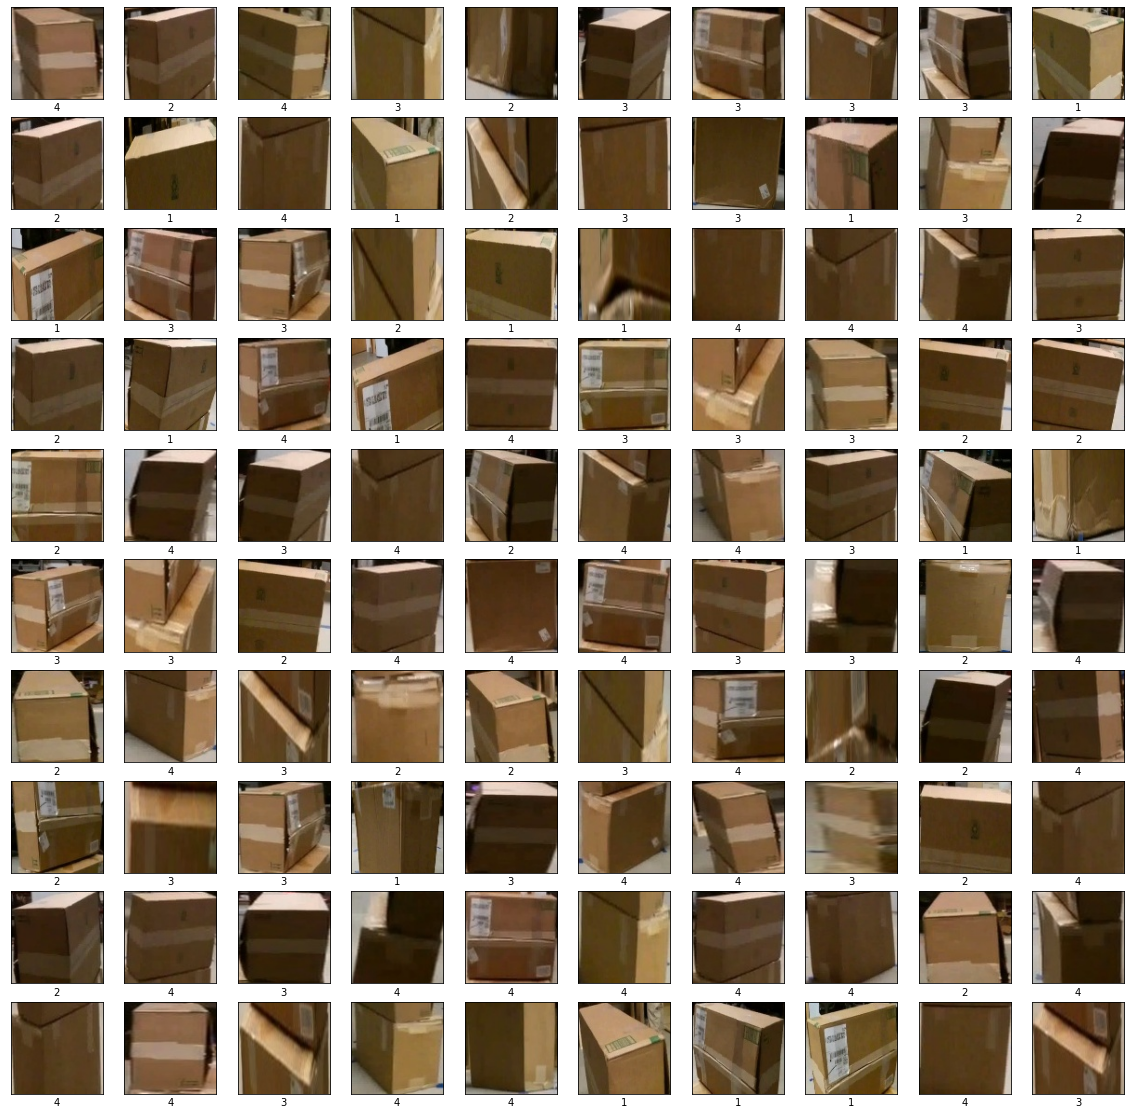

Main: All images finished.


In [4]:
#test that file opens and show images
#---open features
pickle_in = open(os.path.join(frameManager.fullPathToResults,"Features2.pickle"), "rb")
X = pickle.load(pickle_in)
pickle_in.close()


#---plot images with labels
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(X[i], dtype = np.uint8), cmap='gray')
    plt.xlabel(Labels2[i])
plt.show()

winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)
print("Main: All images finished.")     

In [5]:
print(Labels2.count('1'))
print(Labels2.count('2'))
print(Labels2.count('3'))
print(Labels2.count('4'))

649
686
831
1168
